# STOFS Event-based Skill Assessment 

## Input Parameters for Event Analysis


- **bucket_name_2d**: Name of the S3 bucket storing STOFS-2d-global data.
- **bucket_name_3d**: Name of the S3 bucket storing STOFS-3d-Atl data.
- **date_range**: Date range in YYYYMMDD format for analysis.
- **cycles_2d**: List of cycle times (in HH format, e.g., 00, 06, 12, 18) for STOFS-2d-Global forecasts.
- **Hours_before_landfall**: Number of hours before landfall for analysis.
- **Region**: Bounding box string defining the region of interest (min_lon, max_lon, min_lat, max_lat).
- **Event_name**: Name of the storm for hurricane track data extraction and file naming.
- **STOFS_file_2d**: File from STOFS-2d-Global for water level skill assessment.
- **STOFS_file_3d**: File from STOFS-3d-Atl for water level skill assessment.




## Tropical Storm Debby

Debby formed as a tropical storm in the southeast Gulf of Mexico, just north of Cuba, on August 3rd, 2024. By the evening of August 4th, 2024, the storm was upgraded to a hurricane as it approached Florida. Debby made landfall in the Big Bend region of Florida’s panhandle as a Category 1 hurricane at 11:00 UTC on August 5th, 2024. It then continued across Florida and Georgia, gradually weakening to a tropical storm while hugging the southeast coast. The storm is forecasted to bring heavy rainfall and flooding from Florida through the Carolinas and up into New England.

During the storm, both STOFS-2D-Global and STOFS-3D-Atlantic operated stably, providing crucial nowcast and forecast data for various stakeholders. This report evaluates the performance of the STOFS components before and during the storm by comparing forecast and nowcast water levels with observations from different CO-OPS stations. Given that stations along the Gulf are situated in wind-dominant regions, we also closely examined the wind forcing data and assessed its accuracy during the storm.


### Figure 1

Hurricane Debby track (copied from national hurricane center website)

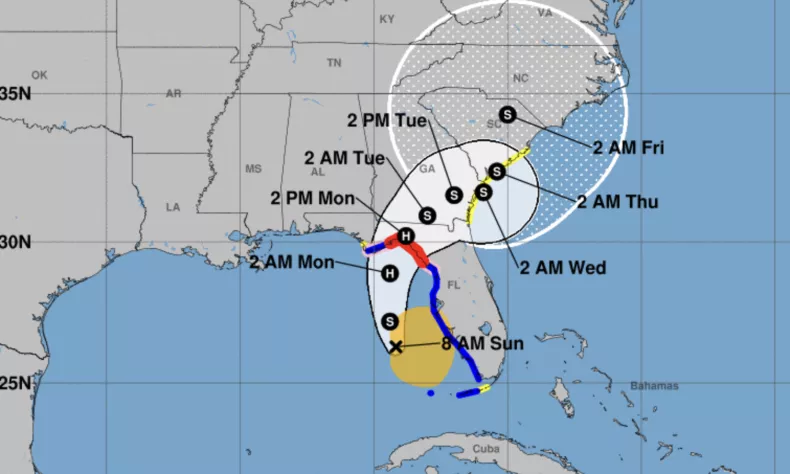




In [9]:
# Import libraries

import dask
import geoviews as gv
import holoviews as hv
import numcodecs
import numpy as np
import pandas as pd
import shapely
import xarray as xr
import matplotlib.pyplot as plt
import s3fs  # Importing the s3fs library for accessing S3 buckets
import time  # Importing the time library for recording execution time
import shapely  # Importing shapely for geometric operations 
import thalassa  # Importing thalassa library for STOFS data analysis
from thalassa import api  # Importing thalassa API for data handling
from thalassa import normalization
from thalassa import utils
from holoviews import opts as hvopts
from holoviews import streams
from holoviews.streams import PointerXY
from holoviews.streams import Tap
import bokeh.plotting as bp
from datetime import datetime, timedelta, timezone
import searvey
from searvey.coops import get_coops_stations
from searvey._coops_api import fetch_coops_station
import tempfile
import pygrib
import math
from typing import List


In [10]:
# Input Parameters for Event Analysis

bucket_name_2d   = 'noaa-gestofs-pds'
bucket_name_3d  = 'noaa-nos-stofs3d-pds'
date_range         = ['20240803','20240805']  
landfall_time_step = 59 # hours after start date from the date range input
cycles_2d        = ['00', '06', '12', '18']  
Hours_before_landfall = 48 # For reading Forecast data
Region       = (-85, -82, 27, 32) # (longitude_min, longitude_max, latitude_min, latitude_max)
Event_name = 'Hurricane Debby'
STOFS_file_2d   = 'points.cwl'
STOFS_file_3d   = 'points.cwl'


In [11]:
# Read STOFS-2d-Global Nowcast Data on the Fly


def read_netcdf_from_s3(bucket_name, key):
    """
    Function to read a NetCDF file from an S3 bucket using thalassa API.
    
    Parameters:
    - bucket_name: Name of the S3 bucket
    - key: Key/path to the NetCDF file in the bucket
    
    Returns:
    - ds: xarray Dataset containing the NetCDF data
    """
    s3 = s3fs.S3FileSystem(anon=True)
    url = f"s3://{bucket_name}/{key}"
    ds = xr.open_dataset(s3.open(url, 'rb'), drop_variables=['nvel'])
    return ds



In [12]:
# Read STOFS-2d-global

bucket_name = bucket_name_2d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1) # to include all nowcast data for the specified rage

dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYY-MM-DD
    current_date += timedelta(days=1)

nowcast_2d_all_list = []
for date in dates:
    for cycle in cycles_2d:
        try: 
           base_key = f'stofs_2d_glo.{date}'
           filename = f't{cycle}z.{STOFS_file_2d}.nc'
           key = f'{base_key}/stofs_2d_glo.{filename}'
           dataset_2d = read_netcdf_from_s3(bucket_name, key)
           nowcast_2d = dataset_2d.isel(time=slice(0, 60)) # the first 6 hr (60 time steps are the nowcast data in STOFS-2D-Global)
           nowcast_2d_all_list.append(nowcast_2d)
        except:
           break
        
nowcast_2d_all = xr.concat(nowcast_2d_all_list, dim='time')

nowcast_2d_all   # a xarray data set containing all the nowcast data


<xarray.Dataset> Size: 120MB
Dimensions:       (time: 960, station: 1688)
Coordinates:
  * time          (time) datetime64[ns] 8kB 2024-08-02T18:06:00 ... 2024-08-0...
Dimensions without coordinates: station
Data variables:
    station_name  (time, station) |S50 81MB b'PSBM1 SOUS41 8410140 ME Eastpor...
    x             (time, station) float64 13MB -66.98 -67.2 ... -51.01 -25.5
    y             (time, station) float64 13MB 44.9 44.65 44.39 ... 58.96 58.96
    zeta          (time, station) float64 13MB -0.6129 -0.6147 ... 0.7927
Attributes: (12/50)
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            noaa.stofs.2d.glo.v2.1.0r1.v55.12
    git_hash:           23947fbd9683d0ef48f12e6ce62d45d18bc27ff3
    grid_type:          Triangular
    description:        2024080300 :-6 hr nowcast and +180 hr forecast ! 32 C...
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

In [13]:
# Read STOFS-2d-global

bucket_name = bucket_name_2d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1) # to include all nowcast data for the specified rage

dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYY-MM-DD
    current_date += timedelta(days=1)

nowcast_2d_all_list = []
for date in dates:
    for cycle in cycles_2d:
         base_key = f'stofs_2d_glo.{date}'
         filename = f't{cycle}z.{STOFS_file_2d}.nc'
         key = f'{base_key}/stofs_2d_glo.{filename}'
         try:
            dataset_2d = read_netcdf_from_s3(bucket_name, key)


            # Check if dataset_2d exists and has data
            if dataset_2d is not None:
                nowcast_2d = dataset_2d.isel(time=slice(0, 60))  # First 60 time steps (nowcast data)
                nowcast_2d_all_list.append(nowcast_2d)
         except Exception as e:
            print(f'Error reading file {key} from S3: {str(e)}')

nowcast_2d_all_out_of_range = xr.concat(nowcast_2d_all_list, dim='time')

nowcast_2d_all = nowcast_2d_all_out_of_range.sel(time=slice(start_date, end_date))    # a xarray data set containing all the nowcast data for the specidified range

nowcast_2d_all

<xarray.Dataset> Size: 90MB
Dimensions:       (time: 721, station: 1688)
Coordinates:
  * time          (time) datetime64[ns] 6kB 2024-08-03 ... 2024-08-06
Dimensions without coordinates: station
Data variables:
    station_name  (time, station) |S50 61MB b'PSBM1 SOUS41 8410140 ME Eastpor...
    x             (time, station) float64 10MB -66.98 -67.2 ... -51.01 -25.5
    y             (time, station) float64 10MB 44.9 44.65 44.39 ... 58.96 58.96
    zeta          (time, station) float64 10MB 1.129 1.105 ... 0.9182 -0.5011
Attributes: (12/50)
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            noaa.stofs.2d.glo.v2.1.0r1.v55.12
    git_hash:           23947fbd9683d0ef48f12e6ce62d45d18bc27ff3
    grid_type:          Triangular
    description:        2024080300 :-6 hr nowcast and +180 hr forecast ! 32 C...
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

In [14]:
# Read STOFS-3d-Atlantic Nowcast Data on the Fly

bucket_name = bucket_name_3d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1) # to include all nowcast data for the specified rage

dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYY-MM-DD
    current_date += timedelta(days=1)

nowcast_3d_all_list = []
for date in dates:
         base_key = f'stofs_3d_atl.{date}'
         filename = 't12z.points.cwl.nc'
         key = f'STOFS-3D-Atl/{base_key}/stofs_3d_atl.{filename}'
         try:
            dataset_3d = read_netcdf_from_s3(bucket_name, key)


            # Check if dataset_2d exists and has data
            if dataset_3d is not None:
                nowcast_3d = dataset_3d.isel(time=slice(0, 240))  # the first 24 hr (240 time steps are the nowcast data)
                nowcast_3d_all_list.append(nowcast_3d)
         except Exception as e:
            print(f'Error reading file {key} from S3: {str(e)}')
       

nowcast_3d_all_out_of_range = xr.concat(nowcast_3d_all_list, dim='time')

nowcast_3d_all = nowcast_3d_all_out_of_range.sel(time=slice(start_date, end_date))    # a xarray data set containing all the nowcast data for the specidified range

nowcast_3d_all   # a xarray data set containing all the nowcast data


<xarray.Dataset> Size: 8MB
Dimensions:       (time: 721, station: 108)
Coordinates:
  * time          (time) datetime64[ns] 6kB 2024-08-03 ... 2024-08-06
Dimensions without coordinates: station
Data variables:
    zeta          (time, station) float64 623kB 0.4209 0.9524 ... 0.3729
    station_name  (time, station) |S50 4MB b'PSBM1 SOUS41 8410140 ME Eastport...
    x             (time, station) float64 623kB 44.9 44.66 43.66 ... 26.06 27.83
    y             (time, station) float64 623kB -66.98 -67.2 ... -97.22 -97.49
    u             (time, station) float64 623kB -1.28 -0.1607 ... 0.2878 -999.0
    v             (time, station) float64 623kB -1.8 0.04055 ... -0.08629 -999.0
    salinity      (time, station) float64 623kB 31.64 32.25 ... 34.49 -999.0
    temperature   (time, station) float64 623kB 10.86 11.52 ... 28.71 -999.0
Attributes:
    title:       SCHISM Model output
    source:      SCHISM model output version v10
    references:  http://ccrm.vims.edu/schismweb/
    history:     Sat Aug  3 18:05:09 2024: ncap2 -O -F -S /lfs/h1/ops/prod/pa...
    NCO:         netCDF Operators version 4.9.7 (Homepage = http://nco.sf.net...

In [15]:
# Find all the CO-OPs stations in the region using searvey
bbox = shapely.box(Region[0], Region[2], Region[1], Region[3])
station_ds= searvey.coops.coops_product_within_region('water_level', region=bbox, start_date=datetime.fromtimestamp(nowcast_2d_all.time.values[0].astype(int) * 1e-9)
, end_date=datetime.fromtimestamp(nowcast_2d_all.time.values[-1].astype(int) * 1e-9))
station_ds


/tmp/ipykernel_11963/811290957.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) coops_product_within_region. (This function is deprecated and will be removed in the future. Replace it with `fetch_coops_station`.) -- Deprecated since version 0.4.0.
  station_ds= searvey.coops.coops_product_within_region('water_level', region=bbox, start_date=datetime.fromtimestamp(nowcast_2d_all.time.values[0].astype(int) * 1e-9)


<xarray.Dataset> Size: 127kB
Dimensions:  (t: 721, nos_id: 7)
Coordinates:
  * t        (t) datetime64[ns] 6kB 2024-08-03 ... 2024-08-06
  * nos_id   (nos_id) object 56B '8726384' '8726607' ... '8727520' '8726724'
    nws_id   (nos_id) <U5 140B 'PMAF1' 'OPTF1' 'EBEF1' ... 'CKYF1' 'CWBF1'
    x        (nos_id) float64 56B -82.56 -82.55 -82.42 ... -84.98 -83.03 -82.83
    y        (nos_id) float64 56B 27.64 27.86 27.92 27.76 29.72 29.14 27.98
Data variables:
    v        (nos_id, t) float32 20kB 0.136 0.139 0.141 ... 1.087 1.094 1.132
    s        (nos_id, t) float32 20kB 0.014 0.017 0.019 ... 0.174 0.141 0.159
    f        (nos_id, t) object 40kB '1,0,0,0' '0,0,0,0' ... '1,0,0,0' '1,0,0,0'
    q        (nos_id, t) object 40kB 'p' 'p' 'p' 'p' 'p' ... 'p' 'p' 'p' 'p' 'p'

In [16]:
# Find CO-OPS station in STOFS-2D-Global station list

# Create an empty list to collect zeta values
zeta_values_list = []
nos_id_points = []
x_values = []
y_values = []
names = []


# Loop over stations and extract zeta if any search string is found in the station name

station_id = np.sort(station_ds['nos_id'].values)

for nos_id in station_id:
  
    for station_index in range(len(nowcast_2d_all.station)):
        station_name = nowcast_2d_all.station_name[0,station_index].item().decode('utf-8').strip()
        if (nos_id in station_name):
           zeta_values = nowcast_2d_all.zeta[:, station_index]  # Extract zeta values for the current station
           x = nowcast_2d_all.x[0, station_index]
           y = nowcast_2d_all.y[0, station_index]
           # Save the availilbe stations in the station list
           nos_id_points.append(nos_id)
           zeta_values_list.append(zeta_values)
           x_values.append(x.item())
           y_values.append(y.item())
           names.append(station_name)
          
# Concatenate all zeta values into a single NumPy array
all_zeta_values = np.concatenate(zeta_values_list, axis=0)

all_zeta_values = np.reshape(all_zeta_values, (int(len(all_zeta_values)/len(nowcast_2d_all.time)),len(nowcast_2d_all.time)))
nos_id_points , names

(['8726384', '8726520', '8726607', '8726724', '8727520', '8728690'],
 ['PMAF1 SOUS42 8726384 FL Port Manatee',
  'SAPF1 SOUS42 8726520 FL St. Petersburg, Tampa Bay',
  'OPTF1 SOUS42 8726607 FL Old Port Tampa',
  'CWBF1 SOUS42 8726724 FL Clearwater Beach',
  'CKYF1 SOUS42 8727520 FL Cedar Key',
  'APCF1 SOUS42 8728690 FL Apalachicola'])

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
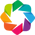

In [17]:
# Plot the stations for STOFS-2d-Global


hv.extension("bokeh")

# Set some defaults for the visualization of the graphs
hvopts.defaults(
    hvopts.Image(
        width=800,
        height=600,
        show_title=True,
        tools=["hover"],
        active_tools=["pan", "box_zoom"],
    ),
)


# The tiles is using the tiling service from Open Street maps
tiles =  api.get_tiles() 

stations = (x_values,y_values)
kb = gv.Points(stations).opts(color="red", marker="circle_dot", size=10)


layout = tiles.opts(width=800, height = 850) * kb 
layout
from bokeh.plotting import show
show(hv.render(layout))

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
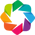

In [18]:
import holoviews as hv
import holoviews.operation.datashader as hvds
import geoviews as gv
from bokeh.plotting import show
import pandas as pd

hv.extension("bokeh")

# Set some defaults for the visualization of the graphs
hv.opts.defaults(
    hv.opts.Image(
        width=800,
        height=600,
        show_title=True,
        tools=["hover"],
        active_tools=["pan", "box_zoom"],
    ),
)

# Assume api.get_tiles() provides the background tiles
tiles = api.get_tiles() 


# Create Points and Text overlays
stations = pd.DataFrame({'x': x_values, 'y': y_values, 'label': nos_id_points})
points = gv.Points(stations, kdims=['x', 'y'], vdims=['label']).opts(
    color="red", marker="circle_dot", size=10
)

labels = gv.Labels(stations, kdims=['x', 'y'], vdims=['label']).opts(
    text_font_size='15pt',
    text_color='gray',
    bgcolor=None,
    xoffset=5,
    yoffset=5
)

# Combine tiles with points and labels
layout = tiles.opts(width=800, height=850) * points * labels
layout

# Display the plot
show(hv.render(layout))




In [19]:
# Find CO-OPS station in STOFS-3D-Atlantic station list


# Create an empty list to collect zeta values
zeta_values_list_3d = []
nos_id_points_3d = []
x_values_3d = []
y_values_3d = []
names_3d = []


# Loop over stations and extract zeta if any search string is found in the station name

for nos_id in station_id:
    
     for station_index in range(len(nowcast_3d_all.station)):
        station_name = nowcast_3d_all.station_name[0,station_index].item().decode('utf-8').strip()  
        if (nos_id in station_name):
           zeta_values = nowcast_3d_all.zeta[:, station_index]  # Extract zeta values for the current station
           x = station_ds['x'][station_ds['nos_id']==nos_id]
           y = station_ds['y'][station_ds['nos_id']==nos_id]
           # Save the availilbe stations in the station list
           nos_id_points_3d.append(nos_id)
           zeta_values_list_3d.append(zeta_values)
           x_values_3d.append(x.item())
           y_values_3d.append(y.item())
           names_3d.append(station_name)
          
# Concatenate all zeta values into a single NumPy array
all_zeta_values_3d = np.concatenate(zeta_values_list_3d, axis=0)

all_zeta_values_3d = np.reshape(all_zeta_values_3d, ( int(len(all_zeta_values_3d)/len(nowcast_3d_all.time)),len(nowcast_3d_all.time)))
nos_id_points_3d , names_3d


(['8726384', '8726520', '8726607', '8726724', '8727520', '8728690'],
 ['PMAF1 SOUS42 8726384 FL Port',
  'SAPF1 SOUS42 8726520 FL St.',
  'OPTF1 SOUS42 8726607 FL Old',
  'CWBF1 SOUS42 8726724 FL Clearwater',
  'CKYF1 SOUS42 8727520 FL Cedar',
  'APCF1 SOUS42 8728690 FL Apalachicola'])

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
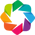

In [20]:
# Plot the stations for STOFS-3d-Atlantic


hv.extension("bokeh")
# Set some defaults for the visualization of the graphs
hvopts.defaults(
    hvopts.Image(
        width=800,
        height=600,
        show_title=True,
        tools=["hover"],
        active_tools=["pan", "box_zoom"],
    ),
)


# The tiles is using the tiling service from Open Street maps
tiles_3d =  api.get_tiles() 

stations_3d = (x_values_3d,y_values_3d)
kb_3d = gv.Points(stations_3d).opts(color="red", marker="circle_dot", size=10)


layout_3d = tiles_3d * kb_3d 
layout_3d

layout_3d = tiles_3d.opts(width=800, height = 850) * kb_3d 
layout_3d
from bokeh.plotting import show
show(hv.render(layout_3d))

In [21]:
# Read Observation data for STOFS-2D-Global

# Initialize an empty DataFrame to store the data
Observation = []

# Loop over each nos_id
for nos_id in nos_id_points:
   
       # Retrieve water level information for the specified date range
       station= searvey.coops.COOPS_Station(int(nos_id)) 
       station_df = station.product(start_date=datetime.fromtimestamp(nowcast_2d_all.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
, end_date=datetime.fromtimestamp(nowcast_2d_all.time.values[-1].astype(int) * 1e-9, tz=timezone.utc), product='water_level',datum='MSL')
      

       # Add the data for the current station to the result DataFrame
       Observation.append(station_df['v'].values)



In [22]:
# Read Observation data for STOFS-3D-Atlantic


# Initialize an empty DataFrame to store the data
Observation_3d = []

# Loop over each nos_id
for nos_id in nos_id_points_3d:
   
       # Retrieve water level information for the specified date range
       station= searvey.coops.COOPS_Station(int(nos_id)) 
       station_df = station.product(start_date=datetime.fromtimestamp(nowcast_2d_all.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
, end_date=datetime.fromtimestamp(nowcast_2d_all.time.values[-1].astype(int) * 1e-9, tz=timezone.utc), product='water_level',datum='NAVD')
      

       # Add the data for the current station to the result DataFrame
       Observation_3d.append(station_df['v'].values)



### Figure 2

The time series comparisons of nowcast STOFS-2D-Global and STOFS-3D-Atlantic simulated (dashed and solid blue lines, respectively) and observed (solid red lines) water levels at different CO-OPS observational locations. The vertical green line corresponds to the landfall time. Note that STOFS-3D-Atlantic water levels were converted from native model output vertical datum (xGEOID20b) to local mean sea level (LMSL) for this analysis.sis.

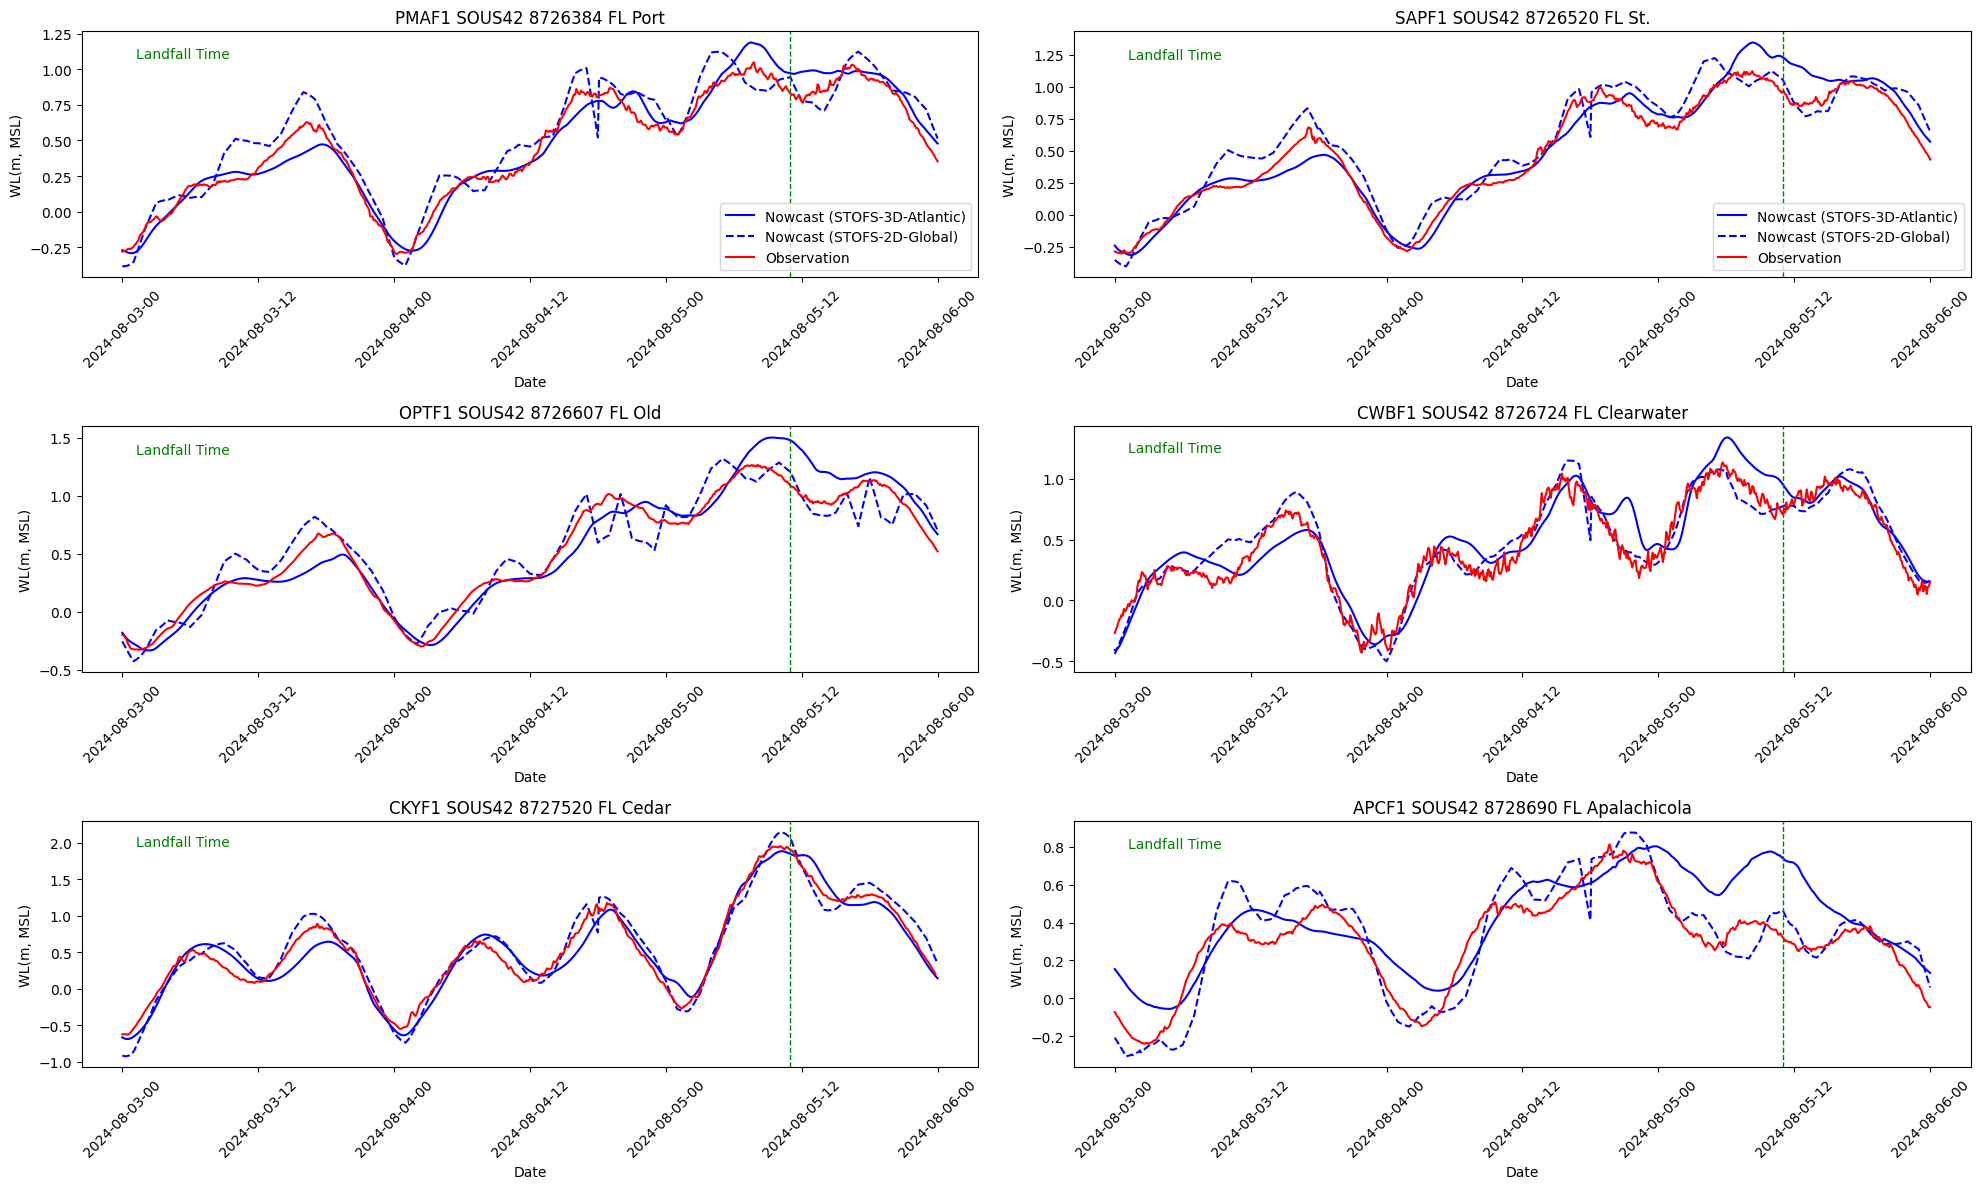

In [23]:

# Convert STOFS-3D-Atl datum to MSL

# From VDatum Package
Conversion_values = [0.116, 0.095, 0.084, 0.094, 0.066, -0.041]







'''
all_zeta_values_3d_MSL = all_zeta_values_3d

for index in range(0, all_zeta_values_3d.shape[0]):
    all_zeta_values_3d_MSL[index] = all_zeta_values_3d[index] + Conversion_values[index]
'''

def convert_to_datetime(time_step, date_range):
    start_date = datetime.strptime(date_range[0], '%Y%m%d')
    time_delta = timedelta(minutes=6)
    return start_date + time_step * time_delta


fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 12))  # 4 rows, 2 columns


index_3d = 0


for row in range(3):  
    for col in range(2):  
        ax = axs[row, col]
        if index_3d < len(nos_id_points_3d):
            ax.plot(all_zeta_values_3d[index_3d, :]+Conversion_values[index_3d], label='Nowcast (STOFS-3D-Atlantic)', color='blue')

            for i in range(0,len(nos_id_points)):
                if nos_id_points[i]== nos_id_points_3d[index_3d]:
                   index_2d = i
                   break
            
            ax.plot(all_zeta_values[i, :], label='Nowcast (STOFS-2D-Global)', color='blue', linestyle='dashed')
            ax.plot(Observation[i][0], label='Observation', color='red')
            ax.set_title(names_3d[index_3d])
            
            ax.set_xlabel('Date')
            
            # Set x ticks and labels
            ax.set_xticks(range(0, len(all_zeta_values_3d[index_3d, :]), 120))
            time_steps = range(0, len(all_zeta_values_3d[index_3d, :]))
            time_labels = [convert_to_datetime(step, date_range) for step in time_steps]
            selected_dates = time_labels[::120]
            ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
            
            ax.axvline(x=landfall_time_step*10, color='green', linestyle='--', linewidth=1)
            ax.text(landfall_time_step*0.9, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
            
            ax.set_ylabel('WL(m, MSL)')
            if row == 0 :
                ax.legend(loc='lower right')
        
        index_3d += 1


plt.tight_layout()
plt.savefig(f'nowcast_{Event_name}')  # Save the figure
plt.show()




In [24]:
# Read STOFS-2d-Global Forecast Data on the Fly


# Read STOFS-2d-global

bucket_name = bucket_name_2d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1) # to include all nowcast data for the specified rage

dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYY-MM-DD
    current_date += timedelta(days=1)

# Find the forecast date
date = (start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%Y%m%d')

# Find the Forecast cycle
date_H = int((start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%H'))

cycle = None
for num in cycles_2d:
    if int(num) < date_H:
        if cycle is None or int(num) > cycle:
            cycle = int(num)
cycle = f'{cycle:02}'


base_key = f'stofs_2d_glo.{date}'
filename = f't{cycle}z.{STOFS_file_2d}.nc'
key = f'{base_key}/stofs_2d_glo.{filename}'
forecast_2d = read_netcdf_from_s3(bucket_name, key)

forecast_2d

<xarray.Dataset> Size: 25MB
Dimensions:       (time: 1860, station: 1688)
Coordinates:
  * time          (time) datetime64[ns] 15kB 2024-08-03T00:06:00 ... 2024-08-...
Dimensions without coordinates: station
Data variables:
    station_name  (station) |S50 84kB ...
    x             (station) float64 14kB ...
    y             (station) float64 14kB ...
    zeta          (time, station) float64 25MB ...
Attributes: (12/50)
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            noaa.stofs.2d.glo.v2.1.0r1.v55.12
    git_hash:           23947fbd9683d0ef48f12e6ce62d45d18bc27ff3
    grid_type:          Triangular
    description:        2024080306 :-6 hr nowcast and +180 hr forecast ! 32 C...
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

In [25]:
# Read STOFS-3d-Atlantic Forecast Data on the Fly


# Read STOFS-3d-Atlantic

bucket_name = bucket_name_3d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1) # to include all nowcast data for the specified rage

dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYY-MM-DD
    current_date += timedelta(days=1)


# Find the forecast date
date = (start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%Y%m%d')


base_key = f'stofs_3d_atl.{date}'
filename = 't12z.points.cwl.nc'
key = f'STOFS-3D-Atl/{base_key}/stofs_3d_atl.{filename}'
forecast_3d = read_netcdf_from_s3(bucket_name, key)

forecast_3d


<xarray.Dataset> Size: 5MB
Dimensions:       (time: 1200, station: 108)
Coordinates:
  * time          (time) datetime64[ns] 10kB 2024-08-02T12:06:00 ... 2024-08-...
Dimensions without coordinates: station
Data variables:
    zeta          (time, station) float64 1MB ...
    station_name  (station) |S50 5kB ...
    x             (station) float64 864B ...
    y             (station) float64 864B ...
    u             (time, station) float64 1MB ...
    v             (time, station) float64 1MB ...
    salinity      (time, station) float64 1MB ...
    temperature   (time, station) float64 1MB ...
Attributes:
    title:       SCHISM Model output
    source:      SCHISM model output version v10
    references:  http://ccrm.vims.edu/schismweb/
    history:     Sat Aug  3 18:05:09 2024: ncap2 -O -F -S /lfs/h1/ops/prod/pa...
    NCO:         netCDF Operators version 4.9.7 (Homepage = http://nco.sf.net...

In [26]:
# Collect Forecast data at CO-OPS stations in STOFS-2D-Global station list

# Create an empty list to collect zeta values
zeta_values_list = []
nos_id_points = []
x_values = []
y_values = []
names = []


# Loop over stations and extract zeta if any search string is found in the station name


    
for nos_id in station_id:
  

   for station_index in range(len(forecast_2d.station)):
        station_name = forecast_2d.station_name[station_index].item().decode('utf-8').strip()  
        if (nos_id in station_name):
           print(nos_id)
           zeta_values = forecast_2d.zeta[:, station_index]  # Extract zeta values for the current station
           x = forecast_2d.x[station_index]
           y = forecast_2d.y[station_index]
           # Save the availilbe stations in the station list
           nos_id_points.append(nos_id)
           zeta_values_list.append(zeta_values)
           x_values.append(x.item())
           y_values.append(y.item())
           names.append(station_name)
          
# Concatenate all zeta values into a single NumPy array
forecast_all_zeta_values = np.concatenate(zeta_values_list, axis=0)

forecast_all_zeta_values = np.reshape(forecast_all_zeta_values, (int(len(forecast_all_zeta_values)/len(forecast_2d.time)),len(forecast_2d.time)))


8726384
8726520
8726607
8726724
8727520
8728690


In [27]:
# Collect Forecast data at CO-OPS stations in STOFS-3D_Atlantic station list

# Create an empty list to collect zeta values
zeta_values_list = []
nos_id_points_3d = []
x_values = []
y_values = []
names_3d = []


# Loop over stations and extract zeta if any search string is found in the station name

    
for nos_id in station_id:
    
    for station_index in range(len(forecast_3d.station)):
        station_name = forecast_3d.station_name[station_index].item().decode('utf-8').strip()  
        if (nos_id in station_name):
           print(nos_id)
           zeta_values = forecast_3d.zeta[:, station_index]  # Extract zeta values for the current station
           x = forecast_3d.x[station_index]
           y = forecast_3d.y[station_index]
           # Save the availilbe stations in the station list
           nos_id_points_3d.append(nos_id)
           zeta_values_list.append(zeta_values)
           x_values.append(x.item())
           y_values.append(y.item())
           names_3d.append(station_name)
          
# Concatenate all zeta values into a single NumPy array
forecast_3d_all_zeta_values = np.concatenate(zeta_values_list, axis=0)

forecast_3d_all_zeta_values = np.reshape(forecast_3d_all_zeta_values, (int(len(forecast_3d_all_zeta_values)/len(forecast_3d.time)),len(forecast_3d.time)))


8726384
8726520
8726607
8726724
8727520
8728690


In [29]:
# Collect the observation data for STOFS-3D-Atlantic

# Initialize an empty DataFrame to store the data
Observation_3d_forecast = []

# Loop over each nos_id
for nos_id in nos_id_points_3d:
   
       # Retrieve water level information for the specified date range
       station= searvey.coops.COOPS_Station(int(nos_id)) 
       station_df = station.product(start_date=datetime.fromtimestamp(forecast_3d.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
, end_date=datetime.fromtimestamp(forecast_3d.time.values[-1].astype(int) * 1e-9, tz=timezone.utc), product='water_level',datum='NAVD')
      

       # Add the data for the current station to the result DataFrame
       Observation_3d_forecast.append(station_df['v'].values)

### Figure 3
The time series comparisons of forecast STOFS-2D-Global simulated (solid blue lines)
and observed (solid red lines) water levels at different CO-OPS observational locations. The
forecasts were made 48 hours before the landfall of the storm Debby. The vertical green line
corresponds to the storm Debby landfall time.

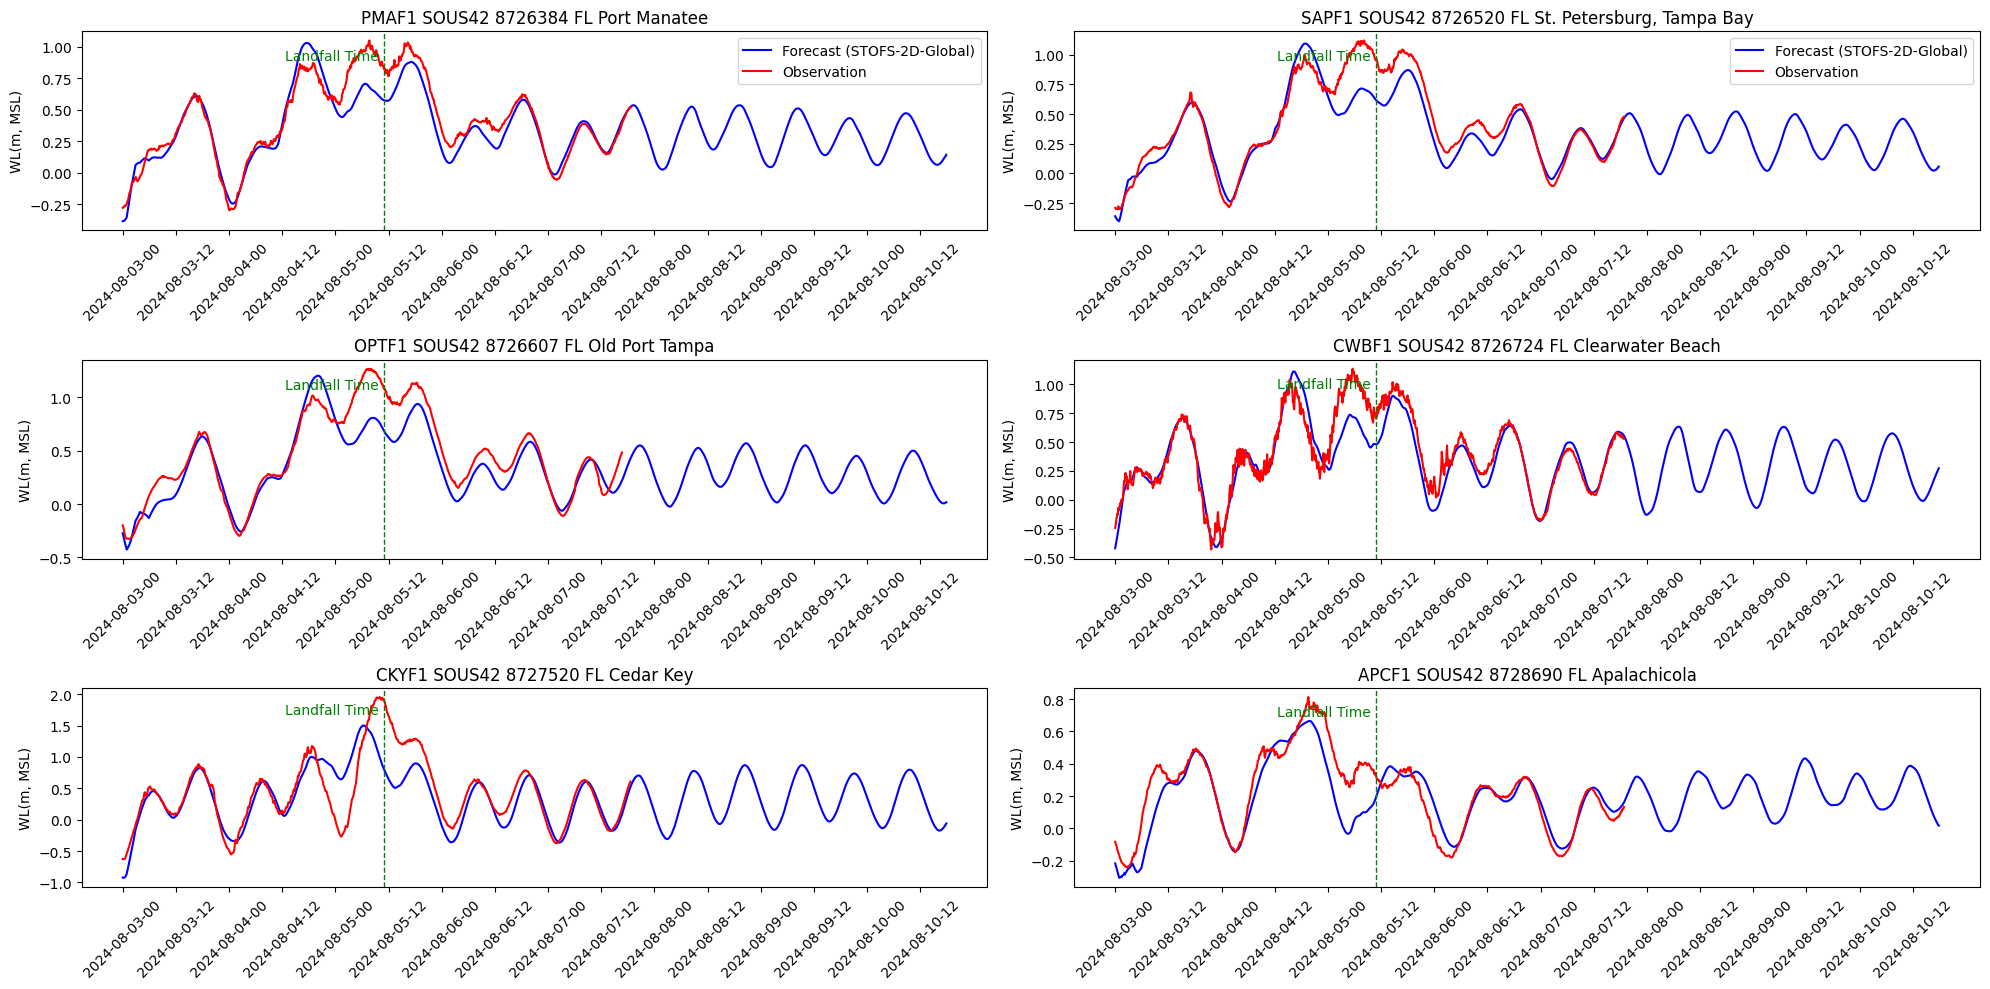

In [30]:
# Plot Forecast for STOFS-2D-Global

def convert_to_datetime(time_step):
    start_date = datetime.fromtimestamp(forecast_2d.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
    time_delta = timedelta(minutes=6)
    return start_date + time_step * time_delta


fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))  # 4 rows, 2 columns


index_3d = 0


for row in range(3):  
    for col in range(2):  
        ax = axs[row, col]
        if index_3d < len(nos_id_points_3d):

            for i in range(0,len(nos_id_points)):
                if nos_id_points[i]== nos_id_points_3d[index_3d]:
                   index_2d = i
                   break
            
            ax.plot(forecast_all_zeta_values[i, :], label='Forecast (STOFS-2D-Global)', color='blue')
            ax.plot(Observation_2d_forecast[i][0], label='Observation', color='red')
            
            ax.set_title(names[i])

            ax.set_xticks(range(0, len(forecast_all_zeta_values[index_2d, :]), 120)) 
            time_steps = range(0, len(forecast_all_zeta_values[index_2d, :]))
            time_labels = [convert_to_datetime(step) for step in time_steps]
            
            # Calculate the landfall time step
            start_date = datetime.strptime(date_range[0], '%Y%m%d')
            landfall_datetime = start_date + timedelta(hours=landfall_time_step)
 
            forecast_2d_landfall_time_step = None 
            
            for step, time_label in zip(time_steps, time_labels): 
                if time_label.replace(tzinfo = None) == landfall_datetime:
                    forecast_2d_landfall_time_step = step 
                    break   
        

            selected_dates = time_labels[::120]
            ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
        
            ax.axvline(x=forecast_2d_landfall_time_step, color='green', linestyle='--', linewidth=1)
            ax.text(forecast_2d_landfall_time_step*0.8, ax.get_ylim()[1]*0.8, 'Landfall Time', color='green', ha='center')
            
            ax.set_ylabel('WL(m, MSL)')
            if row == 0 :
                ax.legend(loc='upper right')
        
        index_3d += 1


plt.tight_layout()
plt.savefig(f'Forecast_2d_{Event_name}')  # Save the figure
plt.show()



### Figure 4

The time series comparisons of forecast STOFS-3D-Atlantic simulated (solid blue lines) and observed (solid red lines) water levels at different CO-OPS observational locations. The forecasts were made 48 hours before the landfall of the storm Debby. The vertical green line corresponds to the landfall time.

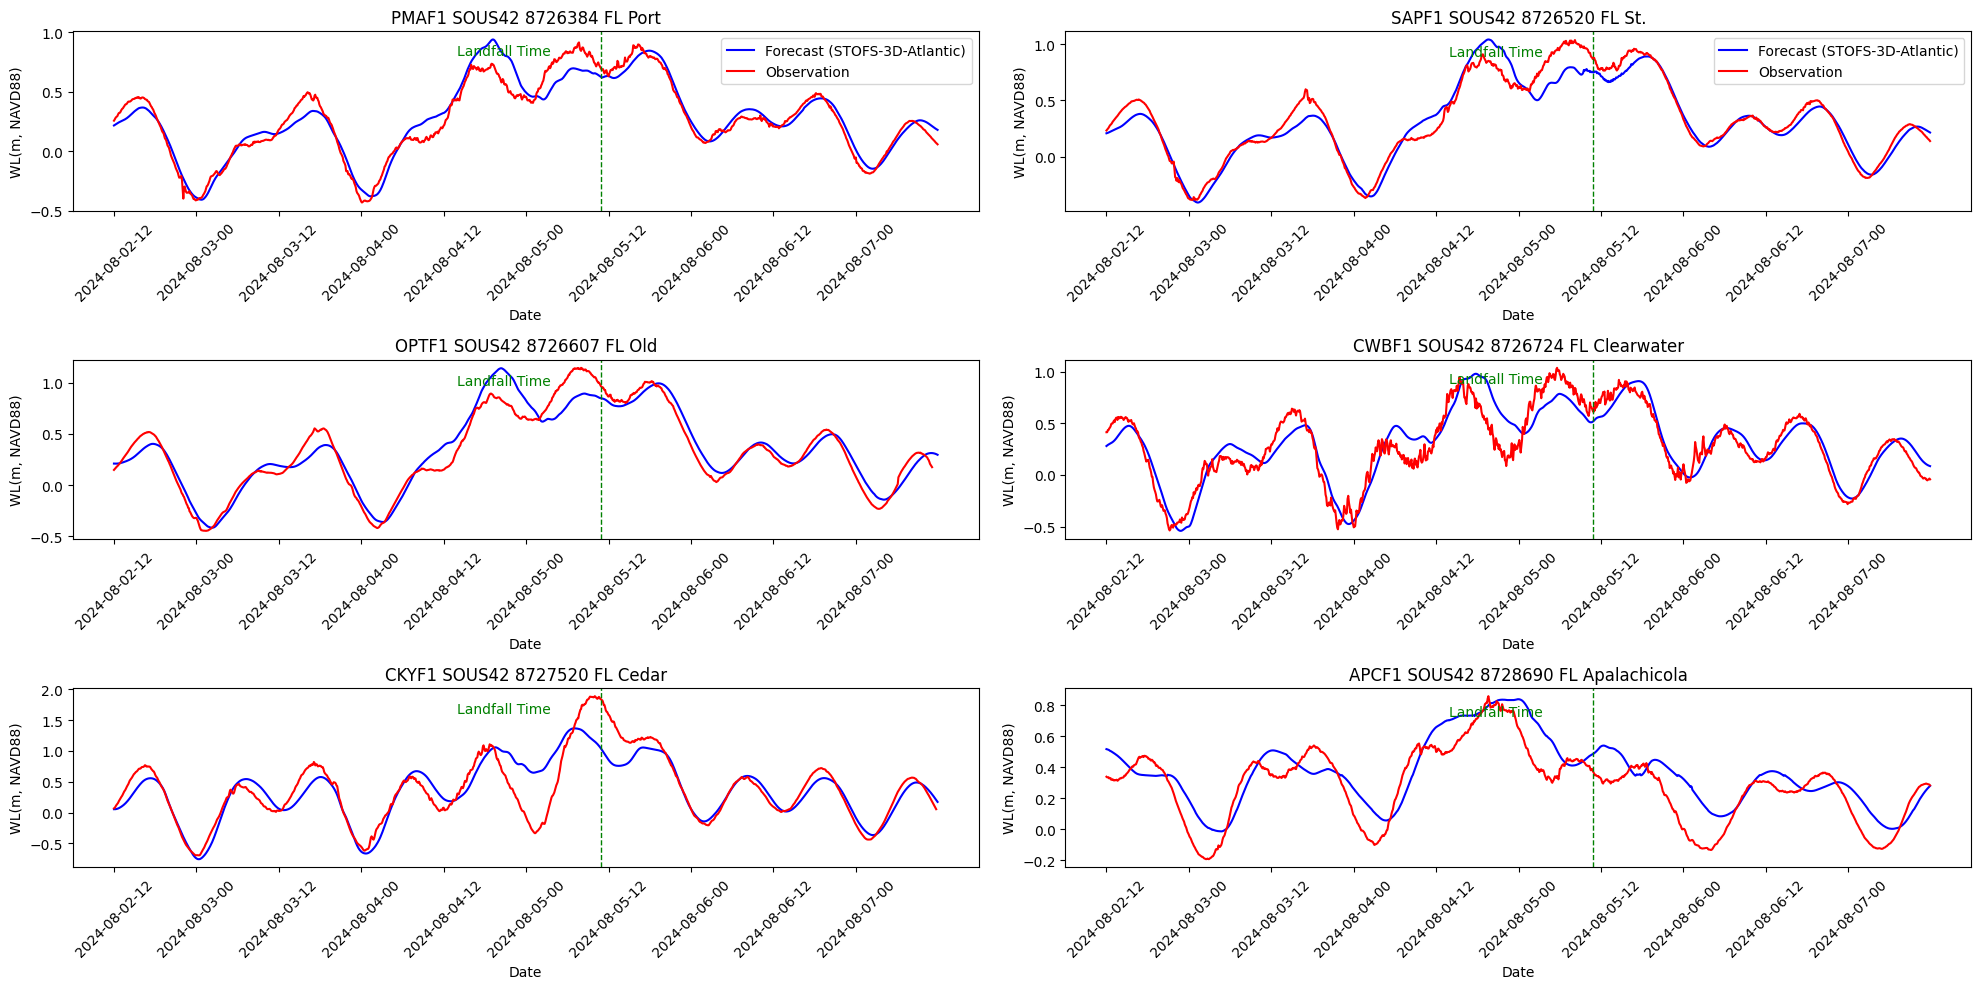

In [31]:
# Plot Forecast for STOFS-3D-Atlantic

def convert_to_datetime(time_step):
    start_date = datetime.fromtimestamp(forecast_3d.time.values[0].astype(int) * 1e-9, tz=timezone.utc)
    time_delta = timedelta(minutes=6)
    return start_date + time_step * time_delta


fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))  # 4 rows, 2 columns


index = 0


for row in range(3):  
    for col in range(2):  
        ax = axs[row, col]
        if index < len(nos_id_points):
            ax.plot(forecast_3d_all_zeta_values[index, :], label='Forecast (STOFS-3D-Atlantic)', color='blue')


            ax.plot(Observation_3d_forecast[index][0], label='Observation', color='red')
            
            ax.set_title(names_3d[index])
            
            ax.set_xlabel('Date')
            
            # Set x ticks and labels
            ax.set_xticks(range(0, len(forecast_3d_all_zeta_values[index, :]), 120)) 
            time_steps = range(0, len(forecast_3d_all_zeta_values[index, :]))
            time_labels = [convert_to_datetime(step) for step in time_steps]
            
            # Calculate the landfall time step
            start_date = datetime.strptime(date_range[0], '%Y%m%d')
            landfall_datetime = start_date + timedelta(hours=landfall_time_step)
 
            forecast_3d_landfall_time_step = None 
            
            for step, time_label in zip(time_steps, time_labels): 
                if time_label.replace(tzinfo = None) == landfall_datetime:
                    forecast_3d_landfall_time_step = step 
                    break   
        
            selected_dates = time_labels[::120]
            ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
   
            ax.axvline(x=forecast_3d_landfall_time_step, color='green', linestyle='--', linewidth=1)
            ax.text(forecast_3d_landfall_time_step*0.8, ax.get_ylim()[1]*0.8, 'Landfall Time', color='green', ha='center')
            
            ax.set_ylabel('WL(m, NAVD88)')
            if row == 0 :
                ax.legend(loc='upper right')
        
        index += 1


plt.tight_layout()
plt.savefig(f'forecast_3d_{Event_name}')  # Save the figure
plt.show()


In [32]:
# Find CO-OPS wind observational stations


bbox = shapely.box(Region[0], Region[2], Region[1], Region[3])
all_stations = get_coops_stations(metadata_source='main', region=bbox)
wind_stations = all_stations[(all_stations.status == 'active') & (all_stations.station_type == 'met')]

wind_stations = wind_stations.sort_values(by ='nos_id')
wind_stations = wind_stations.reset_index()


wind_stations

nos_id nws_id station_type                       name state        lon  \
0   8726384  PMAF1          met               Port Manatee    FL -82.562103   
1   8726412  MTBF1          met           Middle Tampa Bay    FL -82.599442   
2   8726520  SAPF1          met             St. Petersburg    FL -82.626900   
3   8726524  GCTF1          met     Gadsden Cut, Tampa Bay    FL -82.516861   
4   8726607  OPTF1          met             Old Port Tampa    FL -82.552803   
5   8726671  SKCF1          met  Sparkman Channel Entrance    FL -82.445274   
6   8726674  EBEF1          met                   East Bay    FL -82.421387   
7   8726679  TSHF1          met          East Bay Causeway    FL -82.425751   
8   8726694  TPAF1          met      TPA Cruise Terminal 2    FL -82.445862   
9   8726724  CWBF1          met           Clearwater Beach    FL -82.831665   
10  8727520  CKYF1          met                  Cedar Key    FL -83.031700   
11  8728690  APCF1          met               Apalachicola    FL -84.980553   

          lat removed  status                    geometry  
0   27.638700     NaT  active  POINT (-82.56210 27.63870)  
1   27.661667     NaT  active  POINT (-82.59944 27.66167)  
2   27.760599     NaT  active  POINT (-82.62690 27.76060)  
3   27.773527     NaT  active  POINT (-82.51686 27.77353)  
4   27.857800     NaT  active  POINT (-82.55280 27.85780)  
5   27.920555     NaT  active  POINT (-82.44527 27.92056)  
6   27.923056     NaT  active  POINT (-82.42139 27.92306)  
7   27.929001     NaT  active  POINT (-82.42575 27.92900)  
8   27.942972     NaT  active  POINT (-82.44586 27.94297)  
9   27.978333     NaT  active  POINT (-82.83167 27.97833)  
10  29.135000     NaT  active  POINT (-83.03170 29.13500)  
11  29.724443     NaT  active  POINT (-84.98055 29.72444)

In [33]:
# Read wind Observation data as an example

station_id = '8726384'
station_wind = fetch_coops_station(
    station_id=station_id,
    start_date=datetime.fromtimestamp(nowcast_2d_all.time.values[0].astype(int) * 1e-9, tz=timezone.utc),
    end_date=datetime.fromtimestamp(nowcast_2d_all.time.values[-1].astype(int) * 1e-9, tz=timezone.utc),
    product='wind',  interval='h'
)
station_wind

8726384: Encountered an error response for {'station_id': '8726384', 'url': URL('https://tidesandcurrents.noaa.gov/api/datagetter?station=8726384&product=wind&datum=MSL&units=metric&time_zone=gmt&format=json&application=oceanmodeling%2Fstormevents&interval=h&begin_date=20240803%2000%3A00&end_date=20240806%2000%3A00'), 'client': <httpx.Client object at 0x2b1dd8619eb0>, 'rate_limit': <multifutures._rate_limit.RateLimit object at 0x2b1dda6ca9f0>, 'product': <COOPS_Product.WIND: 'wind'>, 'redirect': True}!
--> No data was found. This product may not be offered at this station at the requested time.
COOPS-8726384: No data. Creating a dummy dataframe


Empty DataFrame
Columns: []
Index: []

In [34]:
# Read GFS Nowcast on the Fly

# Initialize empty DataFrames to store wind and pressure data
u_wind_dfs = pd.DataFrame()
v_wind_dfs = pd.DataFrame()
surface_pressure_dfs = pd.DataFrame()


# Initialize list to store all time information 
all_times = []



# Loop over different files for different dates and hours
dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  
    current_date += timedelta(days=1)


for date in dates:
    print(date)
    for i, cycle in enumerate(cycles_2d): 

        print(cycle)
        for hour in range(0, 6, 1):  # Assuming we want to loop from 0 to 120 hours
            print(hour)
      
            if cycle == '00':
                current_date = datetime.strptime(date, '%Y%m%d') 
                current_date -= timedelta(days=1) # Go back one day 
                date_one_day_back = current_date.strftime('%Y%m%d')
                one_cycle_back = '18'

                # Define the filename and the location of the GRIB2 file
                key = f'gfs.{date_one_day_back}/{one_cycle_back}/atmos/gfs.t{one_cycle_back}z.sfluxgrbf{hour:03d}.grib2'
                url = f"s3://noaa-gfs-bdp-pds/{key}"
                time = datetime.strptime(date_one_day_back, '%Y%m%d') + timedelta(hours=int(one_cycle_back)) + timedelta(hours=hour) 

            else:
                previous_cycle = cycles_2d[i - 1] 
                cycle = previous_cycle 

                # Define the filename and the location of the GRIB2 file
                key = f'gfs.{date}/{cycle}/atmos/gfs.t{cycle}z.sfluxgrbf{hour:03d}.grib2'
                url = f"s3://noaa-gfs-bdp-pds/{key}"
                time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=int(cycle)) + timedelta(hours=hour) 

            

            # Fetch the GRIB2 data from S3
            s3 = s3fs.S3FileSystem(anon=True)
            with s3.open(url, 'rb') as f:
                 grib_data = f.read()


            # Define the variable names of interest
            variable_names = ['Surface pressure', '10 metre U wind component', '10 metre V wind component']


            # Initialize empty arrays to store data
            data_arrays = {var_name: [] for var_name in variable_names}


            # Save the GRIB2 data to a temporary file
            with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
                 tmp_file.write(grib_data)
                 tmp_file.seek(0)  # Reset file pointer to the beginning
                 # Read the GRIB2 data using pygrib from the temporary file
                 grbs = pygrib.open(tmp_file.name)


            # Iterate over each message in the GRIB2 file
            for grb in grbs:
                 # Check if the message corresponds to one of the variables of interest
                 
                 if grb['name'] in variable_names:
                    # Append data to the corresponding array
                    data_arrays[grb['name']].append(grb.values)


            # Close the GRIB2 file
            grbs.close()

            # Convert data arrays to xarray DataArrays
            pressure_data = xr.DataArray(np.array(data_arrays['Surface pressure']), name='surface_pressure')
            u_wind_data = xr.DataArray(np.array(data_arrays['10 metre U wind component']), name='u_wind')
            v_wind_data = xr.DataArray(np.array(data_arrays['10 metre V wind component']), name='v_wind')


            # Create an xarray Dataset
            ds = xr.Dataset(
            data_vars={
            'surface_pressure': pressure_data,
            'u_wind': u_wind_data,
            'v_wind': v_wind_data},
             coords={
            'latitude': grb.latitudes,  # Assuming latitudes are the same for all messages
            'longitude': grb.longitudes,},
             attrs={
            'description': 'GRIB Data Example'})


            # Rename the dimensions 'dim_0', 'dim_1', 'dim_2' to 'time', 'y', 'x'
            ds = ds.rename({'dim_0': 'time', 'dim_1': 'y', 'dim_2': 'x'})
    
            # Initialize empty DataFrames to store wind and pressure data for this hour
            u_wind_df = pd.DataFrame()
            v_wind_df = pd.DataFrame()
            surface_pressure_df = pd.DataFrame()
    
            # Loop over the elements of station_ds['y'] and station_ds['x']
            for y_val, x_val, nos_id in zip(wind_stations['lat'], wind_stations['lon'], wind_stations['nos_id']):
                 # Adjust target_longitude to be in the range of 0 to 360
                 longitude_adjusted = float(x_val) + 360 if float(x_val) < 0 else float(x_val)


                 # Find the index of the nearest latitude and longitude in the dataset
                 lat_idx = np.where((np.abs(ds['latitude'][0:4718592:3072] - float(y_val))) == np.min(np.abs(ds['latitude'][0:4718592:3072] - float(y_val))))
                 lon_idx = np.where((np.abs(ds['longitude'][0:3072] - longitude_adjusted)) == np.min(np.abs(ds['longitude'][0:3072] - longitude_adjusted)))
                 

                 # Extract the forcing data using the index
                 u_wind_value = ds.u_wind[0, lat_idx[0][0], lon_idx[0][0]].values
                 v_wind_value = ds.v_wind[0, lat_idx[0][0], lon_idx[0][0]].values
                 surface_pressure_value = ds.surface_pressure[0, lat_idx[0][0], lon_idx[0][0]].values


                 # Append the values to the respective DataFrames as columns with NOS ids as column names
                 u_wind_df[int(nos_id)] = [np.round(u_wind_value, 2)]
                 v_wind_df[int(nos_id)]= [np.round(v_wind_value, 2)]
                 surface_pressure_df[int(nos_id)] = [np.round(surface_pressure_value, 2)]


            u_wind_dfs = pd.concat([u_wind_dfs, u_wind_df], ignore_index=True)
            v_wind_dfs = pd.concat([v_wind_dfs, v_wind_df], ignore_index=True)
            surface_pressure_dfs = pd.concat([surface_pressure_dfs, surface_pressure_df], ignore_index=True)
            
            # Store the time information 
            all_times.append(time) 
            
            
            
# Convert all_times list to DataFrame 
time_df = pd.DataFrame({'Time': all_times}) # Print or use time_df as needed print(time_df)

time_df


20240803
00
0
1
2
3
4
5
06
0
1
2
3
4
5
12
0
1
2
3
4
5
18
0
1
2
3
4
5
20240804
00
0
1
2
3
4
5
06
0
1
2
3
4
5
12
0
1
2
3
4
5
18
0
1
2
3
4
5
20240805
00
0
1
2
3
4
5
06
0
1
2
3
4
5
12
0
1
2
3
4
5
18
0
1
2
3
4
5
20240806
00
0
1
2
3
4
5
06
0
1
2
3
4
5
12
0
1
2
3
4
5
18
0
1
2
3
4
5


Time
0  2024-08-02 18:00:00
1  2024-08-02 19:00:00
2  2024-08-02 20:00:00
3  2024-08-02 21:00:00
4  2024-08-02 22:00:00
..                 ...
91 2024-08-06 13:00:00
92 2024-08-06 14:00:00
93 2024-08-06 15:00:00
94 2024-08-06 16:00:00
95 2024-08-06 17:00:00

[96 rows x 1 columns]

In [36]:

# Initialize an empty DataFrame to store the data
Wind_Observation_2d_Nowcast = []
valid_nos_ids = list(wind_stations['nos_id'])  # List of all nos_ids

# Loop over each nos_id
for nos_id in valid_nos_ids.copy():  # Use a copy of the list to avoid modifying it while iterating
    try:
        # Retrieve wind information for the specified date range
        station_wind = fetch_coops_station(
            station_id=nos_id,
            start_date=time_df['Time'][0],
            end_date=time_df['Time'].iloc[-1],  # Use iloc[-1] to get the last element
            product='wind',  
            interval='h'
        )
        # Add the data for the current station to the result DataFrame
        Wind_Observation_2d_Nowcast.append(station_wind['speed'])
    except Exception as e:  # Catch the specific exception and print the error message
        print(f'{nos_id} has no wind data. Error: {e}')
        valid_nos_ids.remove(nos_id)  # Remove the nos_id from the list if an exception occurs

# Create a new DataFrame with the valid nos_ids
filtered_wind_stations = wind_stations[wind_stations['nos_id'].isin(valid_nos_ids)]

# Output or further process the results
print(Wind_Observation_2d_Nowcast)
print(filtered_wind_stations)



/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
8726384: Encountered an error response for {'station_id': '8726384', 'url': URL('https://tidesandcurrents.noaa.gov/api/datagetter?station=8726384&product=wind&datum=MSL&units=metric&time_zone=gmt&format=json&application=oceanmodeling%2Fstormevents&interval=h&begin_date=20240802%2018%3A00&end_date=20240806%2017%3A00'), 'client': <httpx.Client object at 0x2b1dc40927b0>, 'rate_limit': <multifutures._rate_limit.RateLimit object at 0x2b1dd861a0c0>, 'product': <COOPS_Product.WIND: 'wind'>, 'redirect': True}!
--> No data was found. This product may not be offered at this station at the requested time.
COOPS-8726384: No data. Creating a dummy dataframe
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packag

8726384 has no wind data. Error: 'speed'


/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
8726524: Encountered an error response for {'station_id': '8726524', 'url': URL('https://tidesandcurrents.noaa.gov/api/datagetter?station=8726524&product=wind&datum=MSL&units=metric&time_zone=gmt&format=json&application=oceanmodeling%2Fstormevents&interval=h&begin_date=20240802%2018%3A00&end_date=20240806%2017%3A00'), 'client': <httpx.Client object at 0x2b1ddbea4680>, 'rate_limit': <multifutures._rate_limit.RateLimit object at 0x2b1ddbd964e0>, 'product': <COOPS_Product.WIND: 'win

8726524 has no wind data. Error: 'speed'


/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
8726674: Encountered an error response for {'station_id': '8726674', 'url': URL('https://tidesandcurrents.noaa.gov/api/datagetter?station=8726674&product=wind&datum=MSL&units=metric&time_zone=gmt&format=json&application=oceanmodeling%2Fstormevents&interval=h&begin_date=20240802%2018%3A00&end_date=20240806%2017%3A00'), 'client': <httpx.Client object at 0x2b1ddbd96d20>, 'rate_limit': <multifutures._rate_limit.RateLimit object at 0x2b1ddbdab3e0>, 'product': <COOPS_Product.WIND: 'win

8726674 has no wind data. Error: 'speed'


/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is ret

[time
2024-08-02 18:00:00+00:00     3.3
2024-08-02 19:00:00+00:00     0.5
2024-08-02 20:00:00+00:00     2.6
2024-08-02 21:00:00+00:00     5.5
2024-08-02 22:00:00+00:00     7.3
                             ... 
2024-08-06 13:00:00+00:00    10.0
2024-08-06 14:00:00+00:00     7.9
2024-08-06 15:00:00+00:00     8.4
2024-08-06 16:00:00+00:00     7.4
2024-08-06 17:00:00+00:00     9.0
Name: speed, Length: 96, dtype: float64, time
2024-08-02 18:00:00+00:00    1.2
2024-08-02 19:00:00+00:00    1.6
2024-08-02 20:00:00+00:00    4.9
2024-08-02 21:00:00+00:00    3.4
2024-08-02 22:00:00+00:00    5.7
                            ... 
2024-08-06 13:00:00+00:00    5.6
2024-08-06 14:00:00+00:00    8.9
2024-08-06 15:00:00+00:00    7.4
2024-08-06 16:00:00+00:00    7.5
2024-08-06 17:00:00+00:00    7.2
Name: speed, Length: 96, dtype: float64, time
2024-08-02 18:00:00+00:00    2.5
2024-08-02 19:00:00+00:00    2.7
2024-08-02 20:00:00+00:00    2.5
2024-08-02 21:00:00+00:00    3.8
2024-08-02 22:00:00+00:00    3.0


### Figure 5

The time series comparisons of nowcast GFS simulated (solid blue lines) and observed (solid red lines) wind speeds at different CO-OPS observational locations. The vertical green line corresponds to the storm landfall time.e.


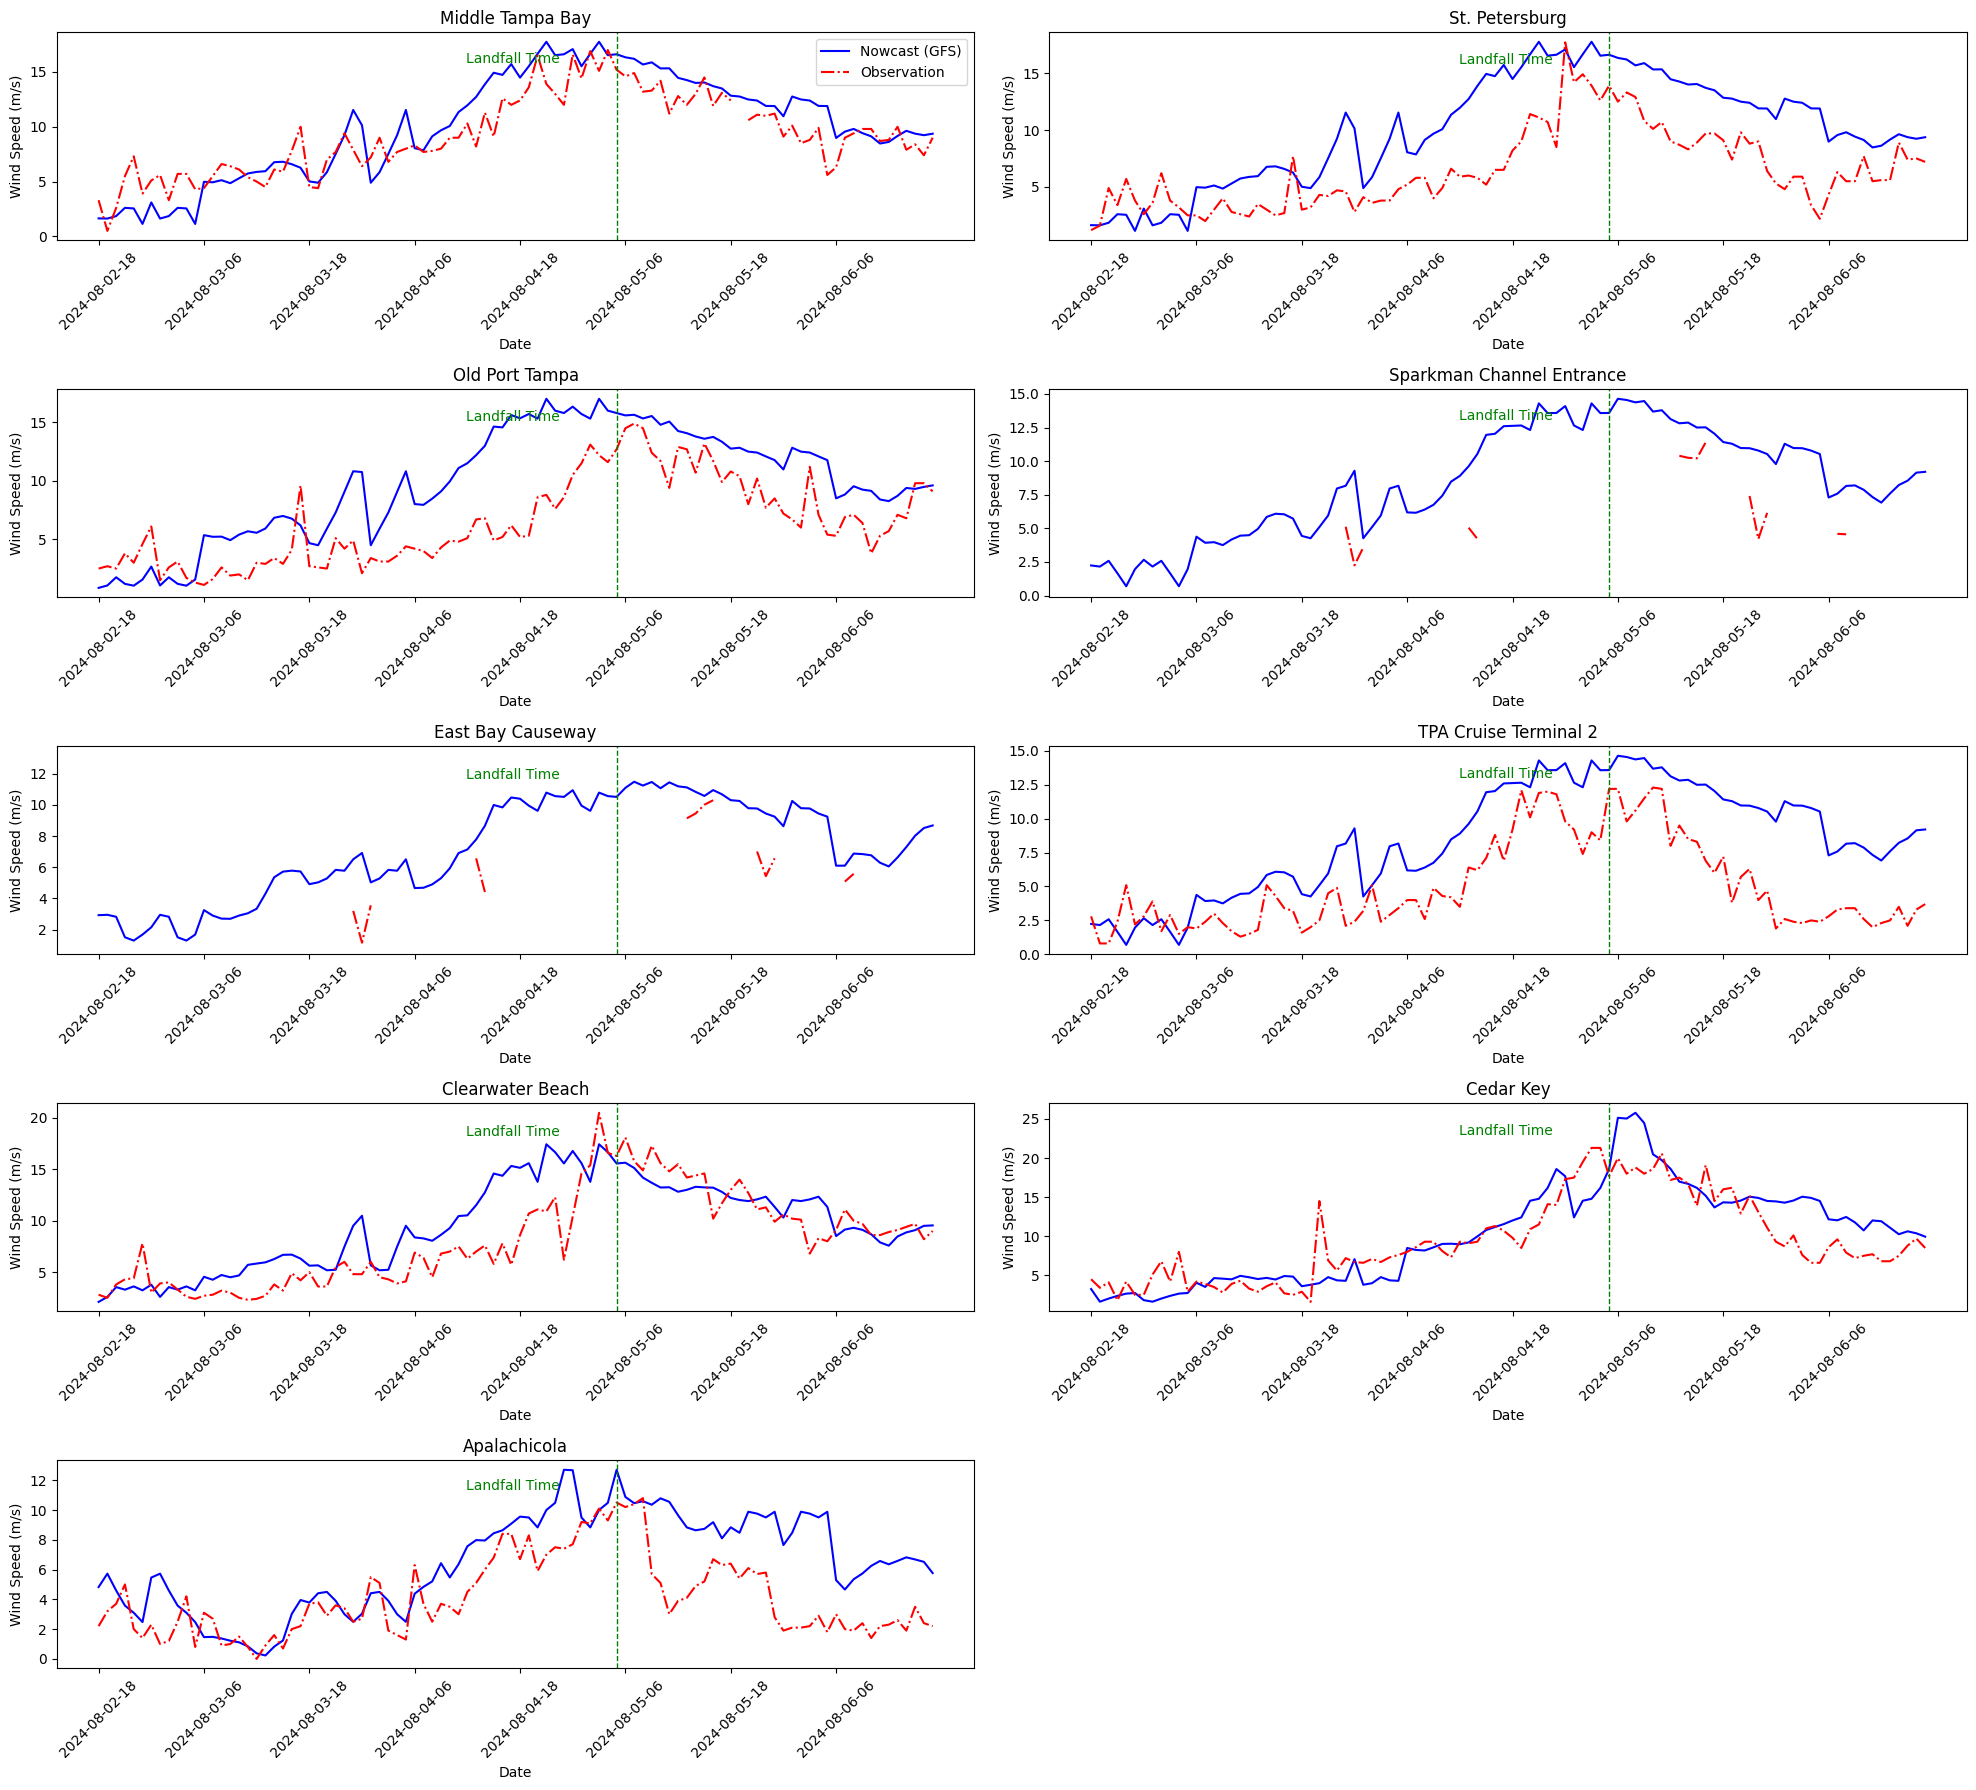

In [37]:
# Plot Nowcast wind 


import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

def convert_to_datetime(time_step):
    start_date = time_df['Time'][0]
    time_delta = timedelta(hours=1)  
    return start_date + time_step * time_delta

# Define the number of rows and columns for subplots (2 columns)
num_rows = 5
num_cols = 2

# Create a figure and axes array with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 18))

index = 0
for row in range(num_rows):
    for col in range(num_cols):
        if index >= len(filtered_wind_stations):
            # If there are fewer stations than subplots, turn off unused subplots
            axs[row, col].axis('off')
            break
            
        
        nos_id = filtered_wind_stations['nos_id'][filtered_wind_stations.index[index]]
        ax = axs[row, col]
        
        # Plot data
        ax.plot(np.sqrt(v_wind_dfs[int(nos_id)]**2 + u_wind_dfs[int(nos_id)]**2)[:len(Wind_Observation_2d_Nowcast[0])], label='Nowcast (GFS)', color='blue')
        ax.plot(Wind_Observation_2d_Nowcast[index].values, label='Observation', color='red', linestyle='dashdot')

        ax.set_title(filtered_wind_stations['name'][filtered_wind_stations.index[index]])
        ax.set_xlabel('Date')
        
        # Set x ticks and labels
        ax.set_xticks(range(0, len(Wind_Observation_2d_Nowcast[0]), 12)) 
        time_steps = range(0, len(Wind_Observation_2d_Nowcast[0]))
        time_labels = [convert_to_datetime(step) for step in time_steps]
        selected_dates = time_labels[::12]
        ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
        
        ax.axvline(x=landfall_time_step , color='green', linestyle='--', linewidth=1)
        ax.text(landfall_time_step * 0.8, ax.get_ylim()[1] * 0.85, 'Landfall Time', color='green', ha='center')
        
        ax.set_ylabel('Wind Speed (m/s)')
        if row == 0 and col == 0:  # Place the legend in the top-left subplot to avoid overlapping
            ax.legend(loc='upper right')
        index += 1
            
          
# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('GFS_Wind_nowcast.png')

# Display the plot
plt.show()



In [38]:
# Read GFS forecast data on the fly

start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1) # to include all nowcast data for the specified rage


# Find the forecast date
date = (start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%Y%m%d')

# Find the Forecast cycle
date_H = int((start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%H'))

cycle = None
for num in cycles_2d:
    if int(num) < date_H:
        if cycle is None or int(num) > cycle:
            cycle = int(num)
cycle = f'{cycle:02}'



# Initialize empty DataFrames to store wind and pressure data
u_wind_dfs_forecast = pd.DataFrame()
v_wind_dfs_forecast = pd.DataFrame()
surface_pressure_dfs_forecast = pd.DataFrame()


# Initialize list to store all time information 
all_times = []



# Loop over different files for different dates and hours



for hour in range(0, 121, 1):  # Assuming we want to loop from 0 to 120 hours
            print(hour)
            if hour < 6:
                 if cycle == '00':
                        current_date = datetime.strptime(date, '%Y%m%d') 
                        current_date -= timedelta(days=1) # Go back one day 
                        date_one_day_back = current_date.strftime('%Y%m%d')
                        one_cycle_back = '18'

                        # Define the filename and the location of the GRIB2 file
                        key = f'gfs.{date_one_day_back}/{one_cycle_back}/atmos/gfs.t{one_cycle_back}z.sfluxgrbf{hour:03d}.grib2'
                        url = f"s3://noaa-gfs-bdp-pds/{key}"
                        time = datetime.strptime(date_one_day_back, '%Y%m%d') + timedelta(hours=int(one_cycle_back)) + timedelta(hours=hour) 

                 else:
                        
                        
                        previous_cycle = cycles_2d[cycles_2d.index('06') - 1] 
                         
                        # Define the filename and the location of the GRIB2 file
                        key = f'gfs.{date}/{previous_cycle}/atmos/gfs.t{previous_cycle}z.sfluxgrbf{hour:03d}.grib2'
                        url = f"s3://noaa-gfs-bdp-pds/{key}"
                        time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=int(previous_cycle)) + timedelta(hours=hour) 

            else: 
                
                # Define the filename and the location of the GRIB2 file
                key = f'gfs.{date}/{cycle}/atmos/gfs.t{cycle}z.sfluxgrbf{hour:03d}.grib2'
                url = f"s3://noaa-gfs-bdp-pds/{key}"
                time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=int(cycle)) + timedelta(hours=hour) 

                

            # Fetch the GRIB2 data from S3
            s3 = s3fs.S3FileSystem(anon=True)
            with s3.open(url, 'rb') as f:
                 grib_data = f.read()


            # Define the variable names of interest
            variable_names = ['Surface pressure', '10 metre U wind component', '10 metre V wind component']


            # Initialize empty arrays to store data
            data_arrays = {var_name: [] for var_name in variable_names}


            # Save the GRIB2 data to a temporary file
            with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
                 tmp_file.write(grib_data)
                 tmp_file.seek(0)  # Reset file pointer to the beginning
                 # Read the GRIB2 data using pygrib from the temporary file
                 grbs = pygrib.open(tmp_file.name)


            # Iterate over each message in the GRIB2 file
            for grb in grbs:
                 # Check if the message corresponds to one of the variables of interest
                 
                 if grb['name'] in variable_names:
                    # Append data to the corresponding array
                    data_arrays[grb['name']].append(grb.values)


            # Close the GRIB2 file
            grbs.close()

            # Convert data arrays to xarray DataArrays
            pressure_data = xr.DataArray(np.array(data_arrays['Surface pressure']), name='surface_pressure')
            u_wind_data = xr.DataArray(np.array(data_arrays['10 metre U wind component']), name='u_wind')
            v_wind_data = xr.DataArray(np.array(data_arrays['10 metre V wind component']), name='v_wind')


            # Create an xarray Dataset
            ds = xr.Dataset(
            data_vars={
            'surface_pressure': pressure_data,
            'u_wind': u_wind_data,
            'v_wind': v_wind_data},
             coords={
            'latitude': grb.latitudes,  # Assuming latitudes are the same for all messages
            'longitude': grb.longitudes,},
             attrs={
            'description': 'GRIB Data Example'})


            # Rename the dimensions 'dim_0', 'dim_1', 'dim_2' to 'time', 'y', 'x'
            ds = ds.rename({'dim_0': 'time', 'dim_1': 'y', 'dim_2': 'x'})
    
            # Initialize empty DataFrames to store wind and pressure data for this hour
            u_wind_df_f = pd.DataFrame()
            v_wind_df_f = pd.DataFrame()
            surface_pressure_df_f = pd.DataFrame()
    
            # Loop over the elements of station_ds['y'] and station_ds['x']
            for y_val, x_val, nos_id in zip(filtered_wind_stations['lat'], filtered_wind_stations['lon'], filtered_wind_stations['nos_id']):
                 # Adjust target_longitude to be in the range of 0 to 360
                 longitude_adjusted = float(x_val) + 360 if float(x_val) < 0 else float(x_val)


                 # Find the index of the nearest latitude and longitude in the dataset
                 lat_idx = np.where((np.abs(ds['latitude'][0:4718592:3072] - float(y_val))) == np.min(np.abs(ds['latitude'][0:4718592:3072] - float(y_val))))
                 lon_idx = np.where((np.abs(ds['longitude'][0:3072] - longitude_adjusted)) == np.min(np.abs(ds['longitude'][0:3072] - longitude_adjusted)))
                 

                 # Extract the forcing data using the index
                 u_wind_value = ds.u_wind[0, lat_idx[0][0], lon_idx[0][0]].values
                 v_wind_value = ds.v_wind[0, lat_idx[0][0], lon_idx[0][0]].values
                 surface_pressure_value = ds.surface_pressure[0, lat_idx[0][0], lon_idx[0][0]].values


                 # Append the values to the respective DataFrames as columns with NOS ids as column names
                 u_wind_df_f[int(nos_id)] = [np.round(u_wind_value, 2)]
                 v_wind_df_f[int(nos_id)]= [np.round(v_wind_value, 2)]
                 surface_pressure_df_f[int(nos_id)] = [np.round(surface_pressure_value, 2)]


            u_wind_dfs_forecast = pd.concat([u_wind_dfs_forecast, u_wind_df_f], ignore_index=True)
            #print(u_wind_dfs_forecast)
            v_wind_dfs_forecast = pd.concat([v_wind_dfs_forecast, v_wind_df_f], ignore_index=True)
            surface_pressure_dfs_forecast = pd.concat([surface_pressure_dfs_forecast, surface_pressure_df_f], ignore_index=True)
            
            # Store the time information 
            all_times.append(time) 
            
   



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


In [39]:
# Read one GFS 3-hourly Data on the Fly


# Loop over different files for different hours
for hour in range(120, 184, 3):  
    print(hour)
    # Define the filename and the location of the GRIB2 file for the current hour

    key_current = f'gfs.{date}/{cycle}/atmos/gfs.t{cycle}z.sfluxgrbf{hour:03d}.grib2'
    url_current = f"s3://noaa-gfs-bdp-pds/{key_current}"
    time = datetime.strptime(date, '%Y%m%d') + timedelta(hours=int(cycle)) + timedelta(hours=hour) 

    # Fetch the GRIB2 data from S3 for the current hour
    s3_current = s3fs.S3FileSystem(anon=True)
    with s3_current.open(url_current, 'rb') as f_current:
        grib_data_current = f_current.read()

    # Define the variable names of interest
    variable_names = ['Surface pressure', '10 metre U wind component', '10 metre V wind component']

    # Initialize empty arrays to store current data
    data_arrays_current = {var_name: [] for var_name in variable_names}

    # Save the current GRIB2 data to a temporary file
    with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
        tmp_file.write(grib_data_current)
        tmp_file.seek(0)  # Reset file pointer to the beginning
        # Read the GRIB2 data using pygrib from the temporary file
        grbs = pygrib.open(tmp_file.name)

        # Iterate over each message in the GRIB2 file
        for grb in grbs:
            # Check if the message corresponds to one of the variables of interest
            if grb['name'] in variable_names:
                # Append data to the corresponding array
                data_arrays_current[grb['name']].append(grb.values)

        # Close the GRIB2 file
        grbs.close()

    
    # Convert data arrays to xarray DataArrays for current data
    pressure_data_current = xr.DataArray(np.array(data_arrays_current['Surface pressure']), name='surface_pressure')
    u_wind_data_current = xr.DataArray(np.array(data_arrays_current['10 metre U wind component']), name='u_wind')
    v_wind_data_current = xr.DataArray(np.array(data_arrays_current['10 metre V wind component']), name='v_wind')

    # Create an xarray Dataset for current data
    ds_current = xr.Dataset(
        data_vars={
            'surface_pressure': pressure_data_current,
            'u_wind': u_wind_data_current,
            'v_wind': v_wind_data_current,
        },
        coords={
            'latitude': grb.latitudes,  # Assuming latitudes are the same for all messages
            'longitude': grb.longitudes,  # Assuming longitudes are the same for all messages
        },
        attrs={
            'description': 'GRIB Data Example',
        },
    )

    # Rename the dimensions 'dim_0', 'dim_1', 'dim_2' to 'time', 'y', 'x'
    ds_current = ds_current.rename({'dim_0': 'time', 'dim_1': 'y', 'dim_2': 'x'})
    
    # Define the filename and the location of the GRIB2 file for the next hour
    hour_next = hour + 3  # Assuming data is available 3-hourly
    key_next = f'gfs.{date}/{cycle}/atmos/gfs.t{cycle}z.sfluxgrbf{hour_next:03d}.grib2'
    url_next = f"s3://noaa-gfs-bdp-pds/{key_next}"
  
    # Fetch the GRIB2 data from S3 for the next hour
    s3_next = s3fs.S3FileSystem(anon=True)
    with s3_next.open(url_next, 'rb') as f_next:
        grib_data_next = f_next.read()

    # Initialize empty arrays to store current data
    data_arrays_next = {var_name: [] for var_name in variable_names}

    # Save the current GRIB2 data to a temporary file
    with tempfile.NamedTemporaryFile(suffix=".grib2") as tmp_file:
        tmp_file.write(grib_data_next)
        tmp_file.seek(0)  # Reset file pointer to the beginning
        # Read the GRIB2 data using pygrib from the temporary file
        grbs = pygrib.open(tmp_file.name)

        # Iterate over each message in the GRIB2 file
        for grb in grbs:
            # Check if the message corresponds to one of the variables of interest
            if grb['name'] in variable_names:
                # Append data to the corresponding array
                data_arrays_next[grb['name']].append(grb.values)

        # Close the GRIB2 file
        grbs.close()


    # Convert data arrays to xarray DataArrays for next file data
    pressure_data_next = xr.DataArray(np.array(data_arrays_next['Surface pressure']), name='surface_pressure')
    u_wind_data_next = xr.DataArray(np.array(data_arrays_next['10 metre U wind component']), name='u_wind')
    v_wind_data_next = xr.DataArray(np.array(data_arrays_next['10 metre V wind component']), name='v_wind')

    # Create an xarray Dataset for next file data
    ds_next = xr.Dataset(
        data_vars={
            'surface_pressure': pressure_data_next,
            'u_wind': u_wind_data_next,
            'v_wind': v_wind_data_next,
        },
        coords={
            'latitude': grb.latitudes,  # Assuming latitudes are the same for all messages
            'longitude': grb.longitudes,  # Assuming longitudes are the same for all messages
        },
        attrs={
            'description': 'GRIB Data Example',
        },
    )

    # Rename the dimensions 'dim_0', 'dim_1', 'dim_2' to 'time', 'y', 'x'
    ds_next = ds_next.rename({'dim_0': 'time', 'dim_1': 'y', 'dim_2': 'x'})

    # Initialize empty DataFrames to store wind and pressure data for this hour
    for hour_1 in range(1, 4, 1): 
        
        u_wind_df = pd.DataFrame()
        v_wind_df = pd.DataFrame()
        surface_pressure_df = pd.DataFrame()
    
        # Loop over the elements of station_ds['y'] and station_ds['x']
        for y_val, x_val, nos_id in zip(filtered_wind_stations['lat'], filtered_wind_stations['lon'], filtered_wind_stations['nos_id']):
            # Adjust target_longitude to be in the range of 0 to 360
            longitude_adjusted = int(x_val) + 360 if int(x_val) < 0 else int(x_val)

            # Find the index of the nearest latitude and longitude in the dataset
            lat_idx = np.where((np.abs(ds_current['latitude'][0:4718592:3072] - int(y_val))) == np.min(np.abs(ds_current['latitude'][0:4718592:3072] - int(y_val))))
            lon_idx = np.where((np.abs(ds_current['longitude'][0:3072] - longitude_adjusted)) == np.min(np.abs(ds_current['longitude'][0:3072] - longitude_adjusted)))

            # Extract the current forcing data using the index 
            u_wind_value_0 = ds_current.u_wind[0, lat_idx[0][0], lon_idx[0][0]].values
            v_wind_value_0 = ds_current.v_wind[0, lat_idx[0][0], lon_idx[0][0]].values
            surface_pressure_value_0 = ds_current.surface_pressure[0, lat_idx[0][0], lon_idx[0][0]].values

            # Extract the next forcing data using the index 
            u_wind_value_3 = ds_next.u_wind[0, lat_idx[0][0], lon_idx[0][0]].values
            v_wind_value_3 = ds_next.v_wind[0, lat_idx[0][0], lon_idx[0][0]].values
            surface_pressure_value_3 = ds_next.surface_pressure[0, lat_idx[0][0], lon_idx[0][0]].values
            
            # Calculate interpolation coefficient
            u_wind_coeff = (u_wind_value_3 - u_wind_value_0) / 3
            v_wind_coeff = (v_wind_value_3 - v_wind_value_0) / 3 
            surface_pressure_coeff = (surface_pressure_value_3 - surface_pressure_value_0) / 3 
                        
            # Append the values to the respective DataFrames as columns with NOS ids as column names
            u_wind_df[int(nos_id)] = [np.round(u_wind_value_0, 2)] + hour_1*u_wind_coeff
            v_wind_df[int(nos_id)]= [np.round(v_wind_value_0, 2)] + hour_1*v_wind_coeff
            surface_pressure_df[int(nos_id)] = [np.round(surface_pressure_value_0, 2)] + hour_1*surface_pressure_coeff

        u_wind_dfs_forecast = pd.concat([u_wind_dfs_forecast, u_wind_df], ignore_index=True)
        v_wind_dfs_forecast = pd.concat([v_wind_dfs_forecast, v_wind_df], ignore_index=True)
        surface_pressure_dfs_forecast = pd.concat([surface_pressure_dfs_forecast, surface_pressure_df], ignore_index=True)
        all_times.append(time) 

# Convert all_times list to DataFrame 
time_df = pd.DataFrame({'Time': all_times}) # Print or use time_df as needed print(time_df)

time_df



120
123
126
129
132
135
138
141
144
147
150
153
156
159
162
165
168
171
174
177
180
183


Time
0   2024-08-03 00:00:00
1   2024-08-03 01:00:00
2   2024-08-03 02:00:00
3   2024-08-03 03:00:00
4   2024-08-03 04:00:00
..                  ...
182 2024-08-10 18:00:00
183 2024-08-10 18:00:00
184 2024-08-10 21:00:00
185 2024-08-10 21:00:00
186 2024-08-10 21:00:00

[187 rows x 1 columns]

In [40]:
# Get Observation Data for forecast Data


# Initialize an empty DataFrame to store the data
Wind_Observation_2d_forecast= []

# Loop over each nos_id
for nos_id in filtered_wind_stations['nos_id']:
   
       # Retrieve wind information for the specified date range
       station_wind = fetch_coops_station(
       station_id=nos_id,
       start_date=time_df['Time'][0],
       end_date=time_df['Time'][len(time_df)-1],
       product='wind',  interval='h')
      

       # Add the data for the current station to the result DataFrame
       #station_wind = station_wind.reset_index()
       Wind_Observation_2d_forecast.append(station_wind['speed'])
Wind_Observation_2d_forecast

/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is ret

[time
 2024-08-03 00:00:00+00:00     5.1
 2024-08-03 01:00:00+00:00     5.6
 2024-08-03 02:00:00+00:00     3.3
 2024-08-03 03:00:00+00:00     5.7
 2024-08-03 04:00:00+00:00     5.7
                              ... 
 2024-08-07 15:00:00+00:00     6.6
 2024-08-07 16:00:00+00:00     9.1
 2024-08-07 17:00:00+00:00    10.7
 2024-08-07 18:00:00+00:00     8.5
 2024-08-07 19:00:00+00:00     9.2
 Name: speed, Length: 116, dtype: float64,
 time
 2024-08-03 00:00:00+00:00    2.6
 2024-08-03 01:00:00+00:00    3.6
 2024-08-03 02:00:00+00:00    6.2
 2024-08-03 03:00:00+00:00    3.8
 2024-08-03 04:00:00+00:00    3.2
                             ... 
 2024-08-07 15:00:00+00:00    7.0
 2024-08-07 16:00:00+00:00    7.0
 2024-08-07 17:00:00+00:00    7.5
 2024-08-07 18:00:00+00:00    5.8
 2024-08-07 19:00:00+00:00    7.7
 Name: speed, Length: 116, dtype: float64,
 time
 2024-08-03 00:00:00+00:00    6.1
 2024-08-03 01:00:00+00:00    1.5
 2024-08-03 02:00:00+00:00    2.6
 2024-08-03 03:00:00+00:00    3.1
 

### Figure 6

The time series comparisons of forecast GFS simulated (solid blue lines) and observed (solid red lines) wind speeds at different CO-OPS observational locations. The forecasts were made 48 hours before the landfall of storm Debby. The vertical green line corresponds to the landfall time.me.



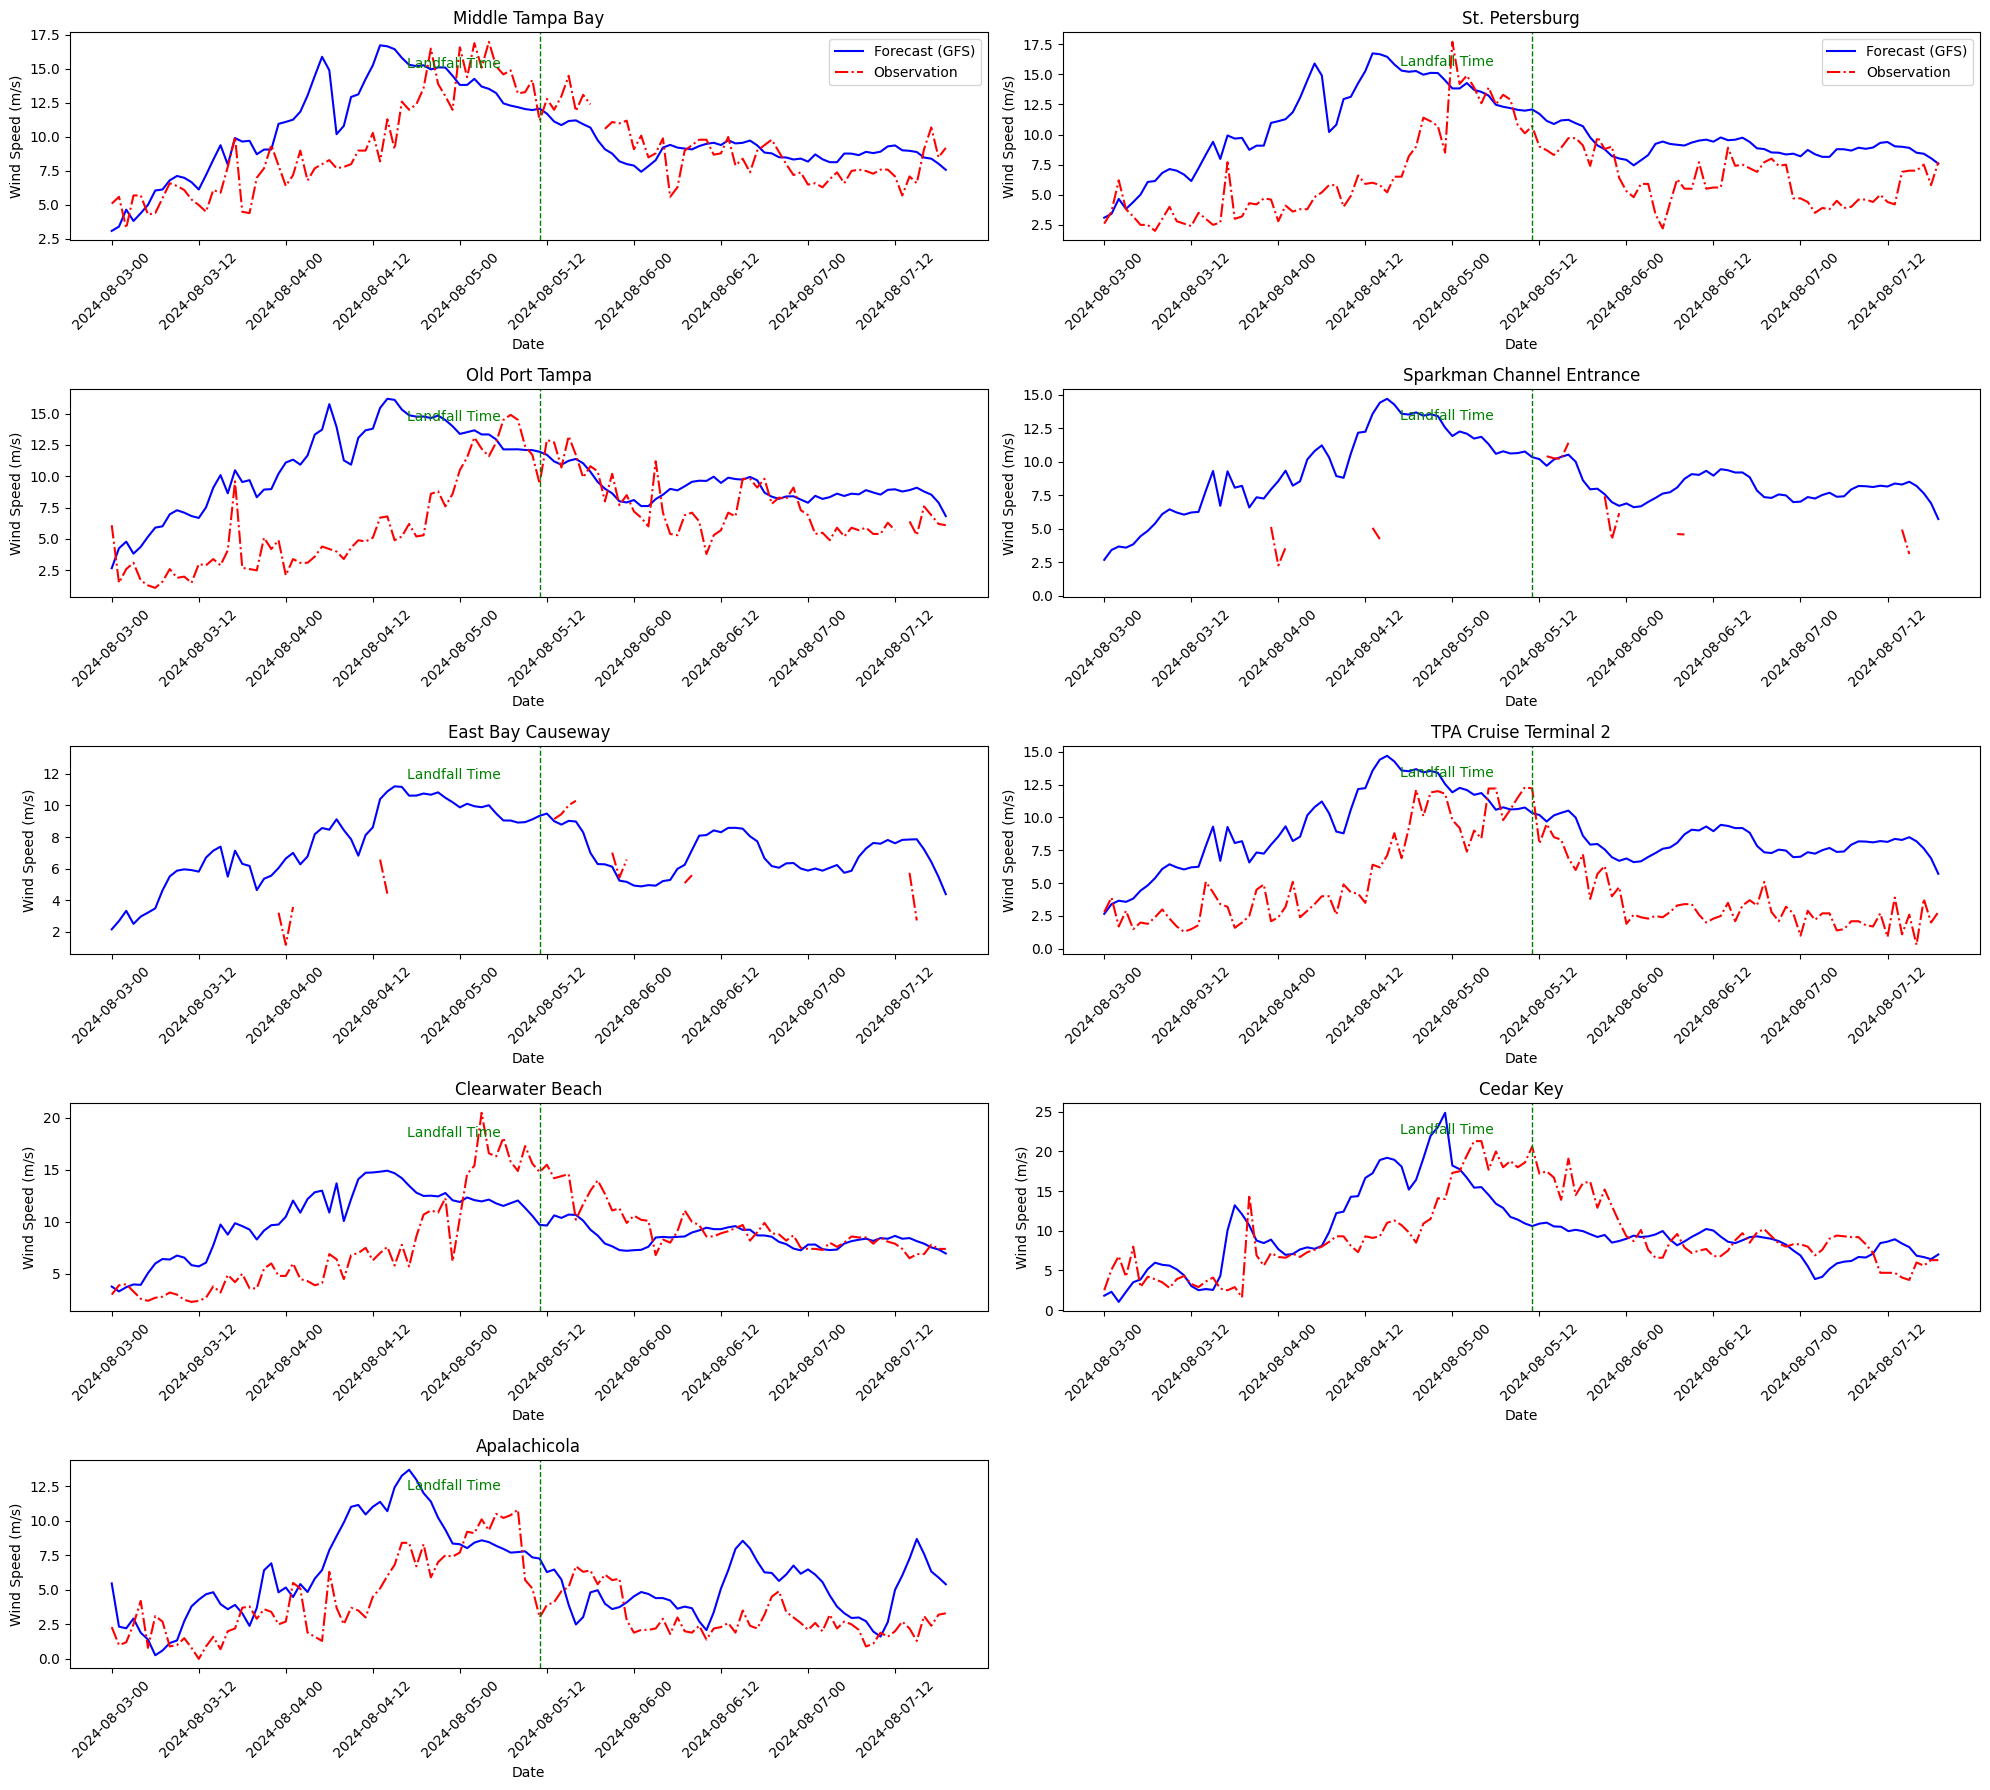

In [41]:
# Plot GFS forecast

def convert_to_datetime(time_step):
    start_date = time_df['Time'][0]
    time_delta = timedelta(hours=1)  
    return start_date + time_step * time_delta


# Define the number of rows and columns for subplots
num_rows = 5
num_cols = 2


# Create a figure and axes array with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 18))



index = 0
for row in range(num_rows):
    for col in range(num_cols):
        if index >= len(filtered_wind_stations['nos_id']):
            axs[row, col].axis('off')
            break
            
        
        nos_id = filtered_wind_stations['nos_id'][filtered_wind_stations.index[index]]
        ax = axs[row, col]
        
        ax.plot(np.sqrt(u_wind_dfs_forecast[int(nos_id)]**2 + v_wind_dfs_forecast[int(nos_id)]**2)[:len(Wind_Observation_2d_forecast[0])], label='Forecast (GFS)', color='blue')
        ax.plot(Wind_Observation_2d_forecast[index].values, label='Observation', color='red',linestyle='dashdot')


        ax.set_title(filtered_wind_stations['name'][filtered_wind_stations.index[index]])
        ax.set_xlabel('Date')

        # Set x ticks and labels
        ax.set_xticks(range(0, len(Wind_Observation_2d_forecast[0]), 12)) 
        time_steps = range(0, len(Wind_Observation_2d_forecast[0]))
        time_labels = [convert_to_datetime(step) for step in time_steps]

        # Calculate the landfall time step
        start_date = datetime.strptime(date_range[0], '%Y%m%d')
        landfall_datetime = start_date + timedelta(hours=landfall_time_step)
 
        forecast_2d_landfall_time_step = None 
    
        for step, time_label in zip(time_steps, time_labels): 

            if time_label == landfall_datetime:
                 forecast_2d_landfall_time_step = step 
                 break   
        

        selected_dates = time_labels[::12]
        ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
        
        ax.axvline(x=forecast_2d_landfall_time_step, color='green', linestyle='--', linewidth=1)
        ax.text(landfall_time_step*0.8, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
        
        ax.set_ylabel('Wind Speed (m/s)')
        if row == 0:
           ax.legend(loc='upper right')
        
        index += 1


# Adjust layout
plt.tight_layout()


# Save the figure
plt.savefig('GFS_Wind_Forecasting.png')


# Display the plot
plt.show()





In [42]:
# Read STOFS-3D-Atl input wind data for nowcast

date = date_range[0]

base_key = f'stofs_3d_atl.{date}'

filename = f'schout_adcirc_{date}.nc'
         
key = f'STOFS-3D-Atl/{base_key}/{filename}'

bucket_name = bucket_name_3d

dataset = read_netcdf_from_s3(bucket_name, key)  # the first 24 hr (240 time steps are the now cast data)


def  get_indices_of_nearest_nodes(ds: xr.Dataset, x: float, y: float, num_nodes: int ) -> List[int]:
    # https://www.unidata.ucar.edu/blogs/developer/en/entry/accessing_netcdf_data_by_coordinates
    # https://github.com/Unidata/python-workshop/blob/fall-2016/notebooks/netcdf-by-coordinates.ipynb
    dist = abs(ds.x - x) ** 2 + abs(ds.y - y) ** 2
    indices_of_nearest_nodes = dist.argsort()[:num_nodes]
    return indices_of_nearest_nodes.values

# Initialize an empty DataFrame to store the data
index = pd.DataFrame()

# Initialize an empty DataFrame to store the data
data = []

for nos_id, x, y in zip(filtered_wind_stations['nos_id'], filtered_wind_stations['lon'], filtered_wind_stations['lat']):
    index_values = get_indices_of_nearest_nodes(dataset, x, y,1)
    data.append({'nos_id': nos_id , 'index_value': index_values})

# Convert the list of dictionaries to a DataFrame
index = pd.DataFrame(data)
index_list = []

for i in range(0,len(index)):
  index_list.append(int(index.index_value[i][0]))

index_list

[1402561,
 1402878,
 1393725,
 1386206,
 1385390,
 1386391,
 1410258,
 2525314,
 2467793]

In [43]:

# Read STOFS-3d-Atlantic


bucket_name = bucket_name_3d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = datetime.strptime(date_range[1], '%Y%m%d')
end_date += timedelta(days=1)  # to include all nowcast data for the specified range


dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYYMMDD
    current_date += timedelta(days=1)


wind_forecast_3d_all_list = []


for date in dates:
    print(date)
    base_key = f'stofs_3d_atl.{date}'
    previous_date = datetime.strptime(date, '%Y%m%d') - timedelta(days=1)
    filename = f'schout_adcirc_{previous_date.strftime("%Y%m%d")}.nc'
    key = f'STOFS-3D-Atl/{base_key}/{filename}'
    
    try:
        forecast_3d = read_netcdf_from_s3(bucket_name, key)
        
        # Calculate square root of sum of squares for uwind and vwind at specific points (nos_id)
        sqrt_uv_sum = np.sqrt(forecast_3d['uwind'][:, index_list]**2 + forecast_3d['vwind'][:, index_list]**2)
        
        # Store the result in a list
        wind_forecast_3d_all_list.append(sqrt_uv_sum)
        
    except Exception as e:
        print(f'Error reading file {key} from S3: {str(e)}')


# Concatenate all datasets along the time dimension
if wind_forecast_3d_all_list:
    wind_concat = xr.concat(wind_forecast_3d_all_list, dim='time')
else:
    print("No valid data found.")


wind_concat


20240803
20240804
20240805
20240806


<xarray.DataArray (time: 96, node: 9)> Size: 7kB
array([[ 2.71912964,  2.65670822,  1.79421629,  1.15095509,  1.01034518,
         1.00083832,  1.67253981,  3.24175715,  0.54439731],
       [ 1.23820272,  1.55196969,  1.09732293,  0.63732199,  0.63753063,
         0.60341973,  1.8151472 ,  2.40478302,  0.5395574 ],
       [ 1.69453116,  2.508307  ,  1.99719757,  1.66925475,  1.66967132,
         1.53541332,  1.75653929,  1.81323811,  1.41378471],
       [ 3.2247946 ,  1.99195758,  1.67763947,  1.86680617,  1.9556558 ,
         1.70281711,  0.70188441,  2.26807871,  2.63778289],
       [ 2.87988407,  2.29867035,  1.85248842,  2.30649906,  2.12483423,
         2.27896917,  2.02487788,  3.14726461,  1.70162439],
       [ 4.55533224,  2.83612699,  1.71866339,  2.30608539,  2.2315064 ,
         2.19038106,  2.7703206 ,  2.51331261,  1.29621567],
       [ 4.72672734,  1.98244042,  1.48217449,  2.04376344,  2.27137673,
         2.34687604,  2.54194865,  3.98076402,  1.97104975],
       [ 0.62006641,  2.67493821,  0.97472569,  1.08362581,  1.25148749,
         1.7052179 ,  4.67026464,  3.42677847,  3.41017019],
       [ 4.34700527,  1.53427605,  2.71742736,  0.99817913,  2.23981495,
         2.01935998,  4.47106048,  1.89166888,  3.57395273],
       [ 3.8233019 ,  4.00384115,  3.28848437,  3.43190552,  1.65036837,
         2.64412842,  3.47718121,  1.30685243,  3.53815926],
...
       [10.02725337,  5.42404327,  6.5325348 ,  5.26103996,  3.08824559,
         4.10153708,  6.82874477, 11.35027374,  5.34580312],
       [ 6.55403873,  4.45847354,  7.32828666,  5.60987364,  4.41727282,
         4.23259573,  7.53631603, 10.61308245,  4.8657614 ],
       [ 6.73516688,  4.35881184,  6.93292118,  5.87914724,  4.65917696,
         4.2225996 ,  8.67360145,  9.79358826,  4.61773348],
       [ 9.74358917,  4.7268098 ,  8.25216208,  6.56409027,  5.13332837,
         4.89474278,  8.09307482, 10.81154582,  5.31549521],
       [10.20966715,  6.09228036,  9.07854294,  6.37078928,  4.68254247,
         4.36239221,  8.07973443, 10.20390128,  4.30966014],
       [ 9.62289281,  4.8620277 ,  7.6835792 ,  6.32221989,  5.02894806,
         4.4871405 ,  8.22413078,  9.93098744,  5.01493366],
       [10.78256088,  6.31225022,  9.1137436 ,  6.95855124,  5.53210324,
         4.99077171,  8.6558034 ,  9.91358006,  5.37195278],
       [10.4177123 ,  5.88308712,  9.28008131,  8.01451509,  6.13895823,
         5.55938781, 10.72317775, 10.01889438,  5.26876367],
       [10.81363242,  6.51456487,  7.16615331,  4.97087855,  4.15219457,
         3.58404532,  7.21467641,  9.89753171,  4.79773296],
       [ 9.7952285 ,  5.70726951,  7.31724304,  5.7465649 ,  4.91435728,
         4.45781115,  8.49337956,  9.91586345,  4.91655844]])
Coordinates:
  * time     (time) datetime64[ns] 768B 2024-08-02T13:00:00 ... 2024-08-06T12...
    x        (node) float64 72B -82.6 -82.63 -82.55 ... -82.83 -83.03 -84.98
    y        (node) float64 72B 27.66 27.76 27.86 27.92 ... 27.98 29.13 29.72
Dimensions without coordinates: node

In [45]:
# Read Wind_observation_data for STOFS-3D-Atl

# Initialize an empty DataFrame to store the data
Wind_Observation_3d_nowcast= []

# Loop over each nos_id
for nos_id in filtered_wind_stations['nos_id']:
   
       # Retrieve wind information for the specified date range
       station_wind = fetch_coops_station(
       station_id=nos_id,
       start_date=wind_concat['time'].values[0],
       end_date=wind_concat['time'].values[-1],
       product='wind',  interval='h')
      

       # Add the data for the current station to the result DataFrame
       #station_wind = station_wind.reset_index()
       Wind_Observation_3d_nowcast.append(station_wind['speed'])
Wind_Observation_3d_nowcast

/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")
/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is ret

[time
 2024-08-02 13:00:00+00:00    2.9
 2024-08-02 14:00:00+00:00    1.7
 2024-08-02 15:00:00+00:00    1.3
 2024-08-02 16:00:00+00:00    0.9
 2024-08-02 17:00:00+00:00    2.9
                             ... 
 2024-08-06 08:00:00+00:00    9.4
 2024-08-06 09:00:00+00:00    9.8
 2024-08-06 10:00:00+00:00    9.8
 2024-08-06 11:00:00+00:00    8.7
 2024-08-06 12:00:00+00:00    8.8
 Name: speed, Length: 96, dtype: float64,
 time
 2024-08-02 13:00:00+00:00    1.9
 2024-08-02 14:00:00+00:00    1.5
 2024-08-02 15:00:00+00:00    1.6
 2024-08-02 16:00:00+00:00    1.4
 2024-08-02 17:00:00+00:00    1.8
                             ... 
 2024-08-06 08:00:00+00:00    5.5
 2024-08-06 09:00:00+00:00    5.5
 2024-08-06 10:00:00+00:00    7.7
 2024-08-06 11:00:00+00:00    5.5
 2024-08-06 12:00:00+00:00    5.6
 Name: speed, Length: 96, dtype: float64,
 time
 2024-08-02 13:00:00+00:00    1.9
 2024-08-02 14:00:00+00:00    1.6
 2024-08-02 15:00:00+00:00    1.6
 2024-08-02 16:00:00+00:00    1.5
 2024-08-02 17

### Figure 7

Time series comparisons of nowcast wind speeds from HRRR data that supplemented with GFS data where HRRR is unavailable simulated (solid blue lines), alongside observed water levels (solid red lines) at different CO-OPS observational locations. The vertical green line corresponds to the storm Debby landfall time.

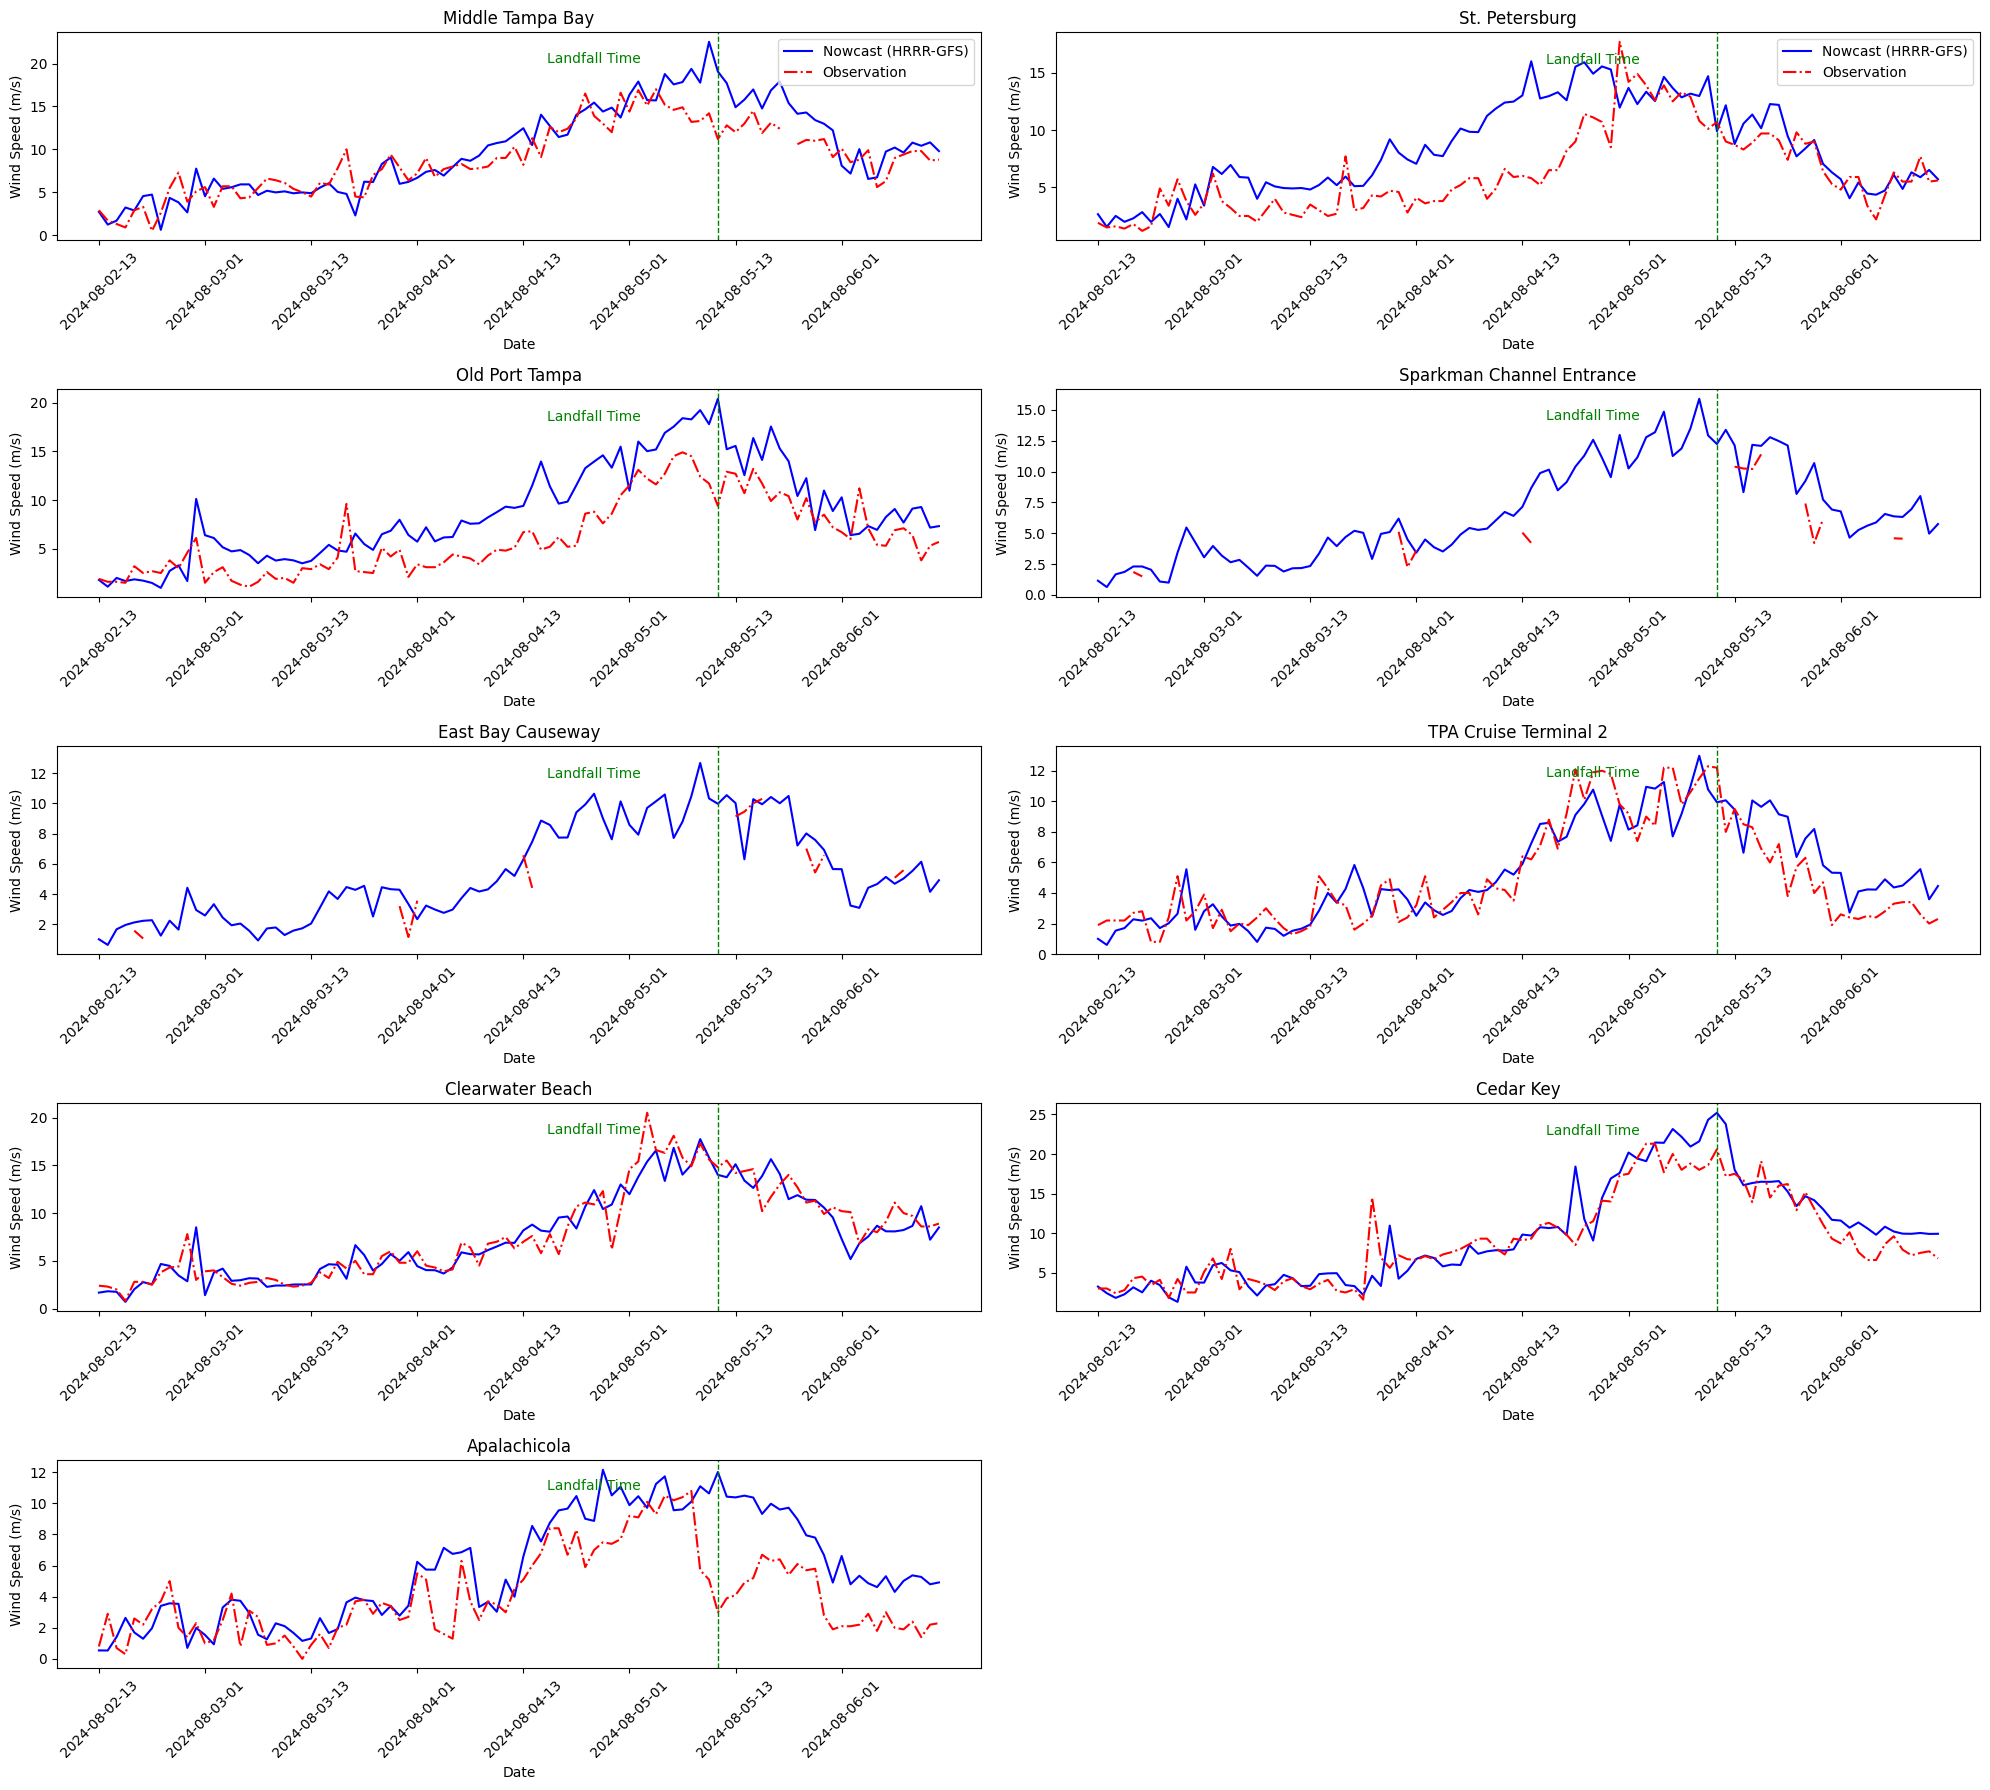

In [46]:
# Plot Wind nowcast data for STOFS-3D-Atl

def convert_to_datetime(time_step):
    start_date = datetime.fromtimestamp(wind_concat['time'].values[0].astype(int) * 1e-9, tz=timezone.utc)
    time_delta = timedelta(hours=1)  
    return start_date + time_step * time_delta


# Define the number of rows and columns for subplots
num_rows = 5
num_cols = 2


# Create a figure and axes array with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 18))



index = 0
for row in range(num_rows):
    for col in range(num_cols):
        if index >= len(filtered_wind_stations['nos_id']):
            axs[row, col].axis('off')
            break
        
        nos_id = filtered_wind_stations['nos_id'][filtered_wind_stations.index[index]]
        ax = axs[row, col]
        
        ax.plot(wind_concat[:,index], label='Nowcast (HRRR-GFS)', color='blue')
        ax.plot(Wind_Observation_3d_nowcast[index].values, label='Observation', color='red',linestyle='dashdot')


        ax.set_title(filtered_wind_stations['name'][filtered_wind_stations.index[index]])
        ax.set_xlabel('Date')

        # Set x ticks and labels
        ax.set_xticks(range(0, len(Wind_Observation_3d_nowcast[0]), 12)) 
        time_steps = range(0, len(Wind_Observation_3d_nowcast[0]))
        time_labels = [convert_to_datetime(step) for step in time_steps]
        
        # Calculate the landfall time step
        start_date = datetime.strptime(date_range[0], '%Y%m%d')
        landfall_datetime = start_date + timedelta(hours=landfall_time_step)
 
        nowcast_3d_landfall_time_step = None 

        for step, time_label in zip(time_steps, time_labels): 

            if time_label.replace(tzinfo = None) == landfall_datetime:
               nowcast_3d_landfall_time_step = step 
               break 

        selected_dates = time_labels[::12]
        ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
        ax.axvline(x=nowcast_3d_landfall_time_step, color='green', linestyle='--', linewidth=1)
        ax.text(nowcast_3d_landfall_time_step*0.8, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
        
        ax.set_ylabel('Wind Speed (m/s)')
        if row == 0:
           ax.legend(loc='upper right')
        
        index += 1


# Adjust layout
plt.tight_layout()


# Save the figure
plt.savefig('STOFS_3D_Wind_Nowcast.png')

# Display the plot
plt.show()




In [47]:
# Read wind Forecast from STOFS-3D-Atl


bucket_name = bucket_name_3d
start_date = datetime.strptime(date_range[0], '%Y%m%d')
end_date = start_date + timedelta(days=5) # Forecast data provided in each STOFS-3D-Atl cycle


# Find the forecast date

dates = []

forecast_date = (start_date + timedelta(hours=landfall_time_step-Hours_before_landfall)).strftime('%Y%m%d')

current_date = datetime.strptime(forecast_date, '%Y%m%d')-timedelta(days=1) #starting from nowcast data
while current_date <= end_date:
    dates.append(current_date.strftime('%Y%m%d'))  # Format as YYYYMMDD
    current_date += timedelta(days=1)


wind_forecast_3d_all_list = []

for date in dates:
    print(date)
    base_key = f'stofs_3d_atl.{forecast_date}'
    filename = f'schout_adcirc_{date}.nc'
    key = f'STOFS-3D-Atl/{base_key}/{filename}'
    
    try:
        wind_forecast_3d = read_netcdf_from_s3(bucket_name, key)
        
        # Calculate square root of sum of squares for uwind and vwind at specific points (nos_id)
        sqrt_uv_sum = np.sqrt(wind_forecast_3d['uwind'][:, index_list]**2 + wind_forecast_3d['vwind'][:, index_list]**2)
        
        # Store the result in a list
        wind_forecast_3d_all_list.append(sqrt_uv_sum)
        
    except Exception as e:
        print(f'Error reading file {key} from S3: {str(e)}')


# Concatenate all datasets along the time dimension
if wind_forecast_3d_all_list:
    wind_concat_forecast = xr.concat(wind_forecast_3d_all_list, dim='time')
else:
    print("No valid data found.")


wind_concat_forecast


20240802
20240803
20240804
20240805
20240806
20240807
Error reading file STOFS-3D-Atl/stofs_3d_atl.20240803/schout_adcirc_20240807.nc from S3: noaa-nos-stofs3d-pds/STOFS-3D-Atl/stofs_3d_atl.20240803/schout_adcirc_20240807.nc
20240808
Error reading file STOFS-3D-Atl/stofs_3d_atl.20240803/schout_adcirc_20240808.nc from S3: noaa-nos-stofs3d-pds/STOFS-3D-Atl/stofs_3d_atl.20240803/schout_adcirc_20240808.nc


<xarray.DataArray (time: 120, node: 9)> Size: 9kB
array([[2.71912964, 2.65670822, 1.79421629, ..., 1.67253981, 3.24175715,
        0.54439731],
       [1.23820272, 1.55196969, 1.09732293, ..., 1.8151472 , 2.40478302,
        0.5395574 ],
       [1.69453116, 2.508307  , 1.99719757, ..., 1.75653929, 1.81323811,
        1.41378471],
       ...,
       [9.5944984 , 9.34556544, 8.66646176, ..., 9.71335018, 6.33363883,
        3.19693155],
       [9.81427574, 9.67851209, 9.01954319, ..., 9.94152783, 6.09341024,
        3.2592292 ],
       [9.87653613, 9.67955585, 9.01778926, ..., 9.94536049, 5.83848355,
        3.32669562]])
Coordinates:
  * time     (time) datetime64[ns] 960B 2024-08-02T13:00:00 ... 2024-08-07T12...
    x        (node) float64 72B -82.6 -82.63 -82.55 ... -82.83 -83.03 -84.98
    y        (node) float64 72B 27.66 27.76 27.86 27.92 ... 27.98 29.13 29.72
Dimensions without coordinates: node

In [48]:
# Read Observation data for forecast wind


# Initialize an empty DataFrame to store the data
Wind_Observation_3d_forecast= []

# Loop over each nos_id
for nos_id in filtered_wind_stations['nos_id']:
       print(nos_id)
       # Retrieve wind information for the specified date range
       station_wind = fetch_coops_station(
       station_id=nos_id,
       start_date=wind_concat_forecast['time'].values[0],
       end_date=wind_concat_forecast['time'].values[-1],
       product='wind',  interval='h')
      

       # Add the data for the current station to the result DataFrame
       #station_wind = station_wind.reset_index()
       Wind_Observation_3d_forecast.append(station_wind['speed'])
Wind_Observation_3d_forecast

8726412


/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")


8726520


/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")


8726607


/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")


8726671


/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")


8726679


/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")


8726694


/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")


8726724


/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")


8727520


/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")


8728690


/nhc/Atieh.Alipour/environment/miniconda3/envs/env_subsetting2/lib/python3.12/site-packages/searvey/_common.py:33: UserWarning: Assuming UTC!
Data is retrieved and stored in UTC time
  warnings.warn("Assuming UTC!\nData is retrieved and stored in UTC time")


[time
 2024-08-02 13:00:00+00:00    2.9
 2024-08-02 14:00:00+00:00    1.7
 2024-08-02 15:00:00+00:00    1.3
 2024-08-02 16:00:00+00:00    0.9
 2024-08-02 17:00:00+00:00    2.9
                             ... 
 2024-08-07 08:00:00+00:00    7.5
 2024-08-07 09:00:00+00:00    7.3
 2024-08-07 10:00:00+00:00    7.6
 2024-08-07 11:00:00+00:00    7.6
 2024-08-07 12:00:00+00:00    7.1
 Name: speed, Length: 120, dtype: float64,
 time
 2024-08-02 13:00:00+00:00    1.9
 2024-08-02 14:00:00+00:00    1.5
 2024-08-02 15:00:00+00:00    1.6
 2024-08-02 16:00:00+00:00    1.4
 2024-08-02 17:00:00+00:00    1.8
                             ... 
 2024-08-07 08:00:00+00:00    4.6
 2024-08-07 09:00:00+00:00    4.6
 2024-08-07 10:00:00+00:00    4.4
 2024-08-07 11:00:00+00:00    5.0
 2024-08-07 12:00:00+00:00    4.4
 Name: speed, Length: 120, dtype: float64,
 time
 2024-08-02 13:00:00+00:00    1.9
 2024-08-02 14:00:00+00:00    1.6
 2024-08-02 15:00:00+00:00    1.6
 2024-08-02 16:00:00+00:00    1.5
 2024-08-02 

### Figure 8

Time series comparisons of forecasted wind speeds from HRRR data that is supplemented with GFS data where HRRR is unavailable simulated (solid blue lines), alongside observed water levels (solid red line) at different CO-OPS observational locations. The forecasts were made 48 hours before the landfall of the storm Debby. The vertical green line corresponds to the landfall time.

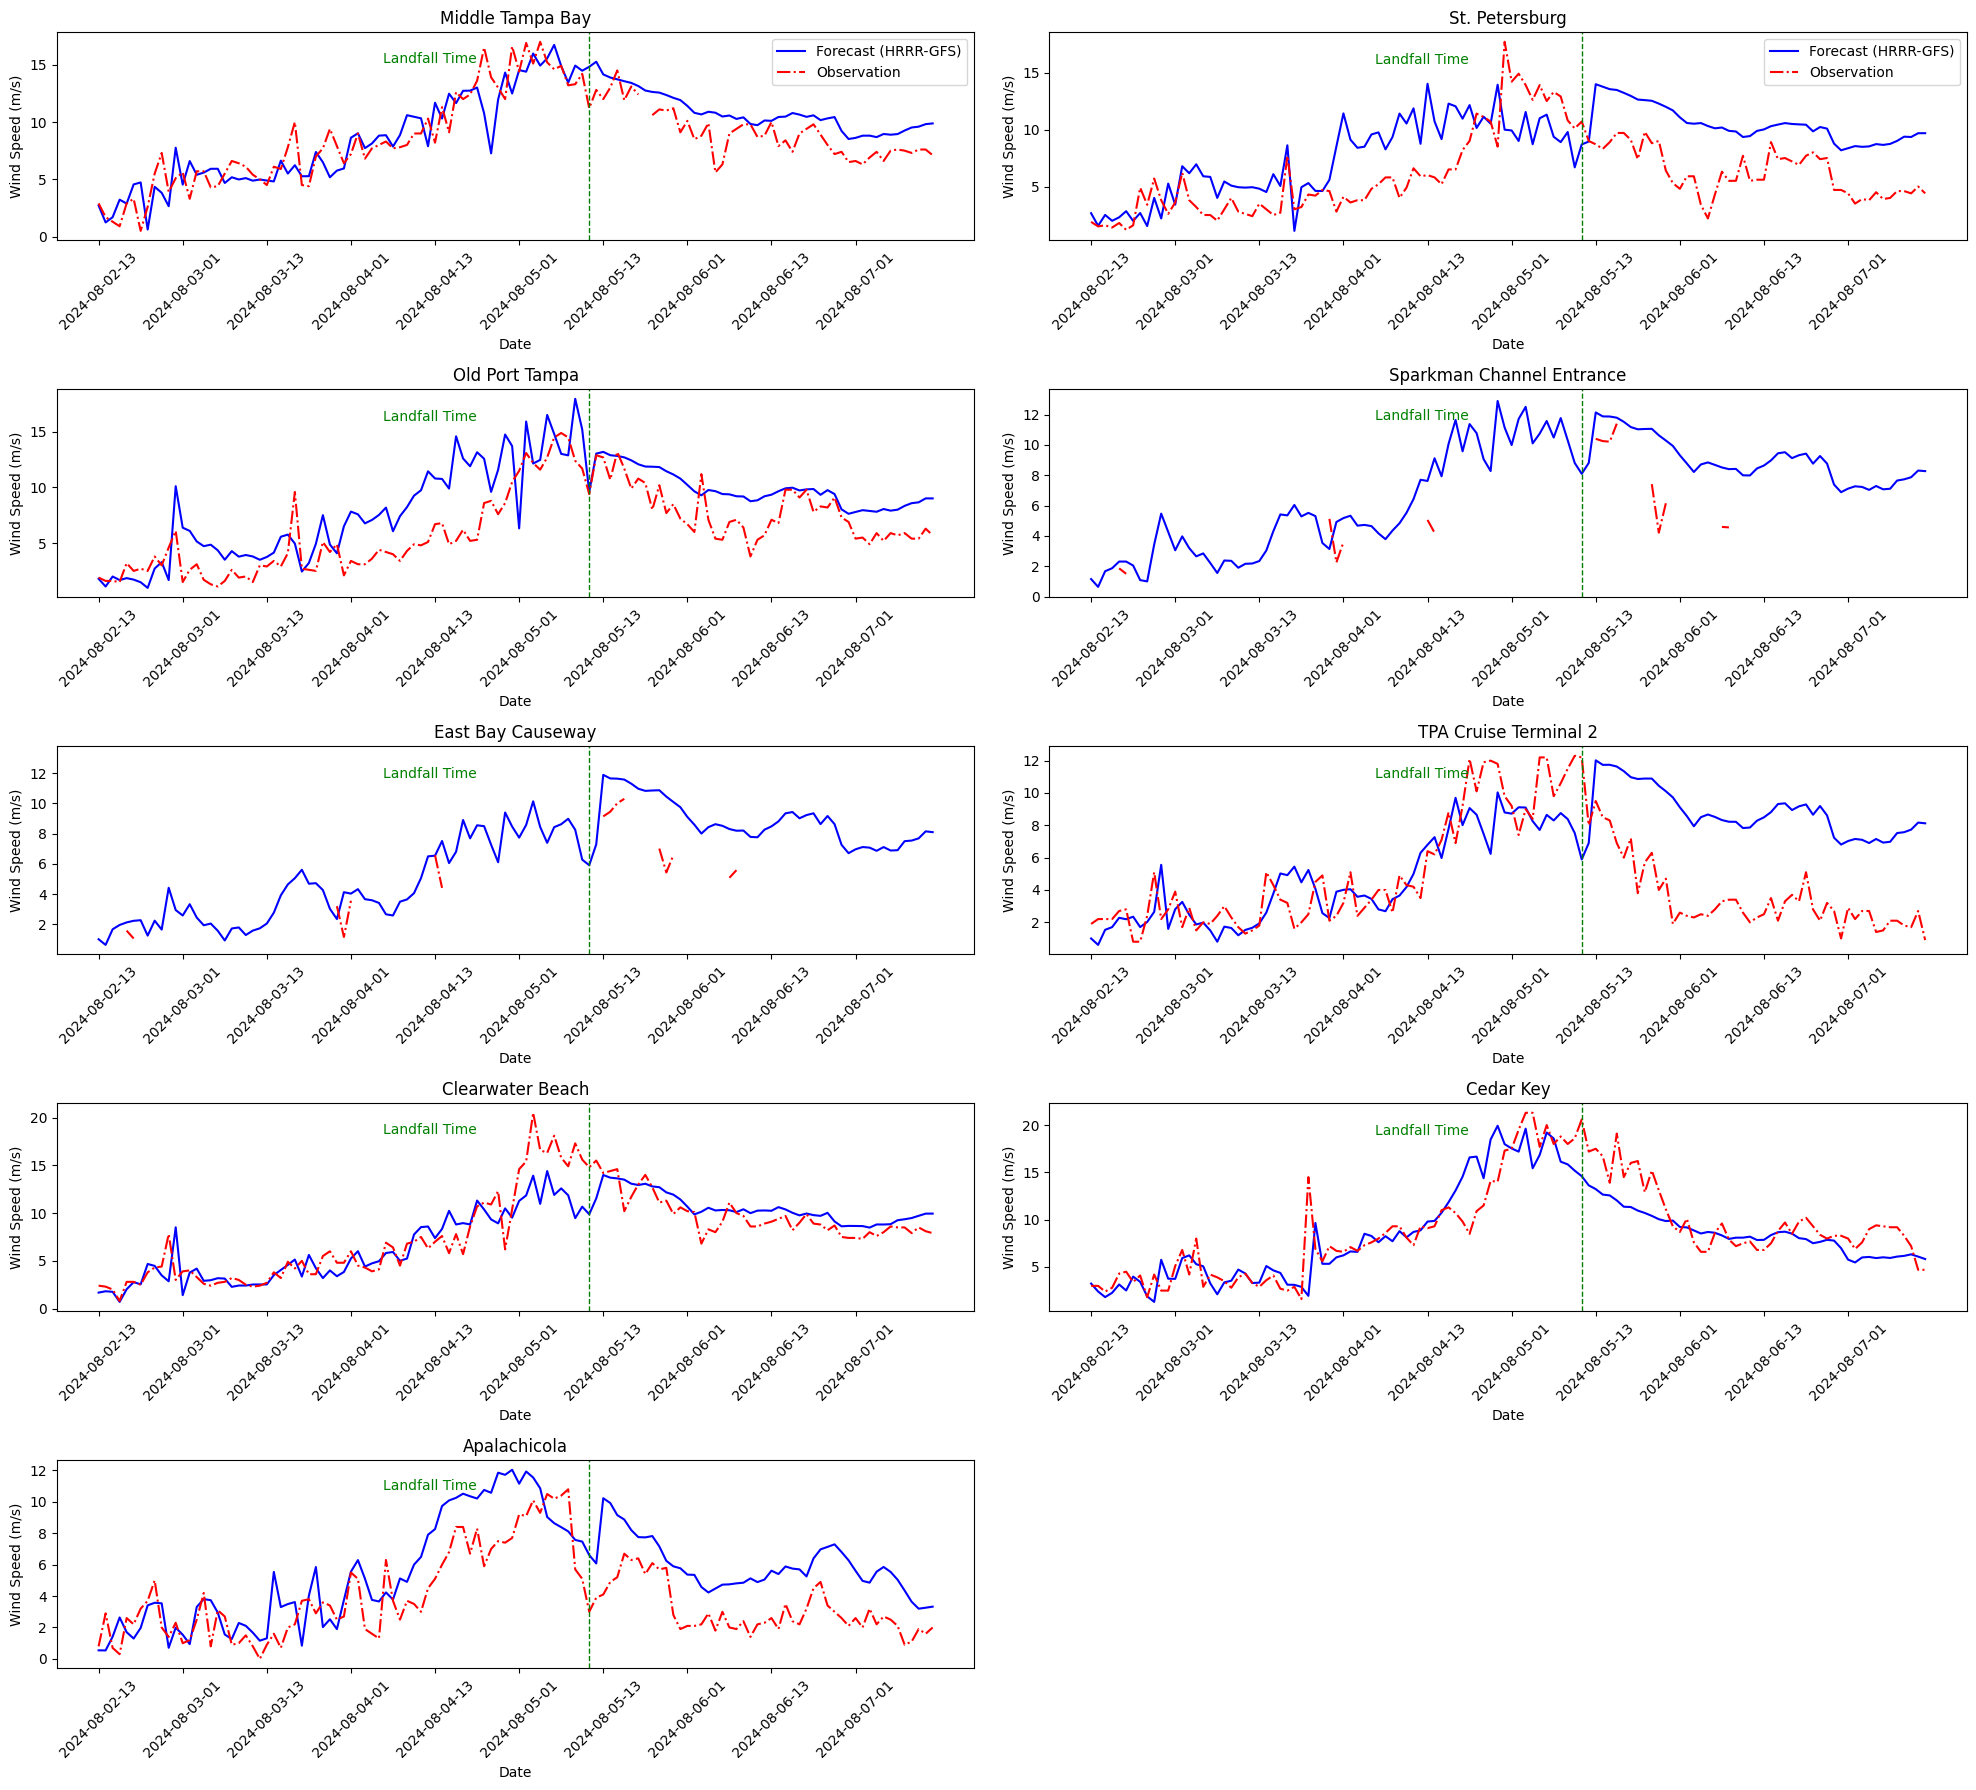

In [49]:
# # Plot wind forecast for STOFS-3D-Atl


def convert_to_datetime(time_step):
    start_date = datetime.fromtimestamp(wind_concat_forecast['time'].values[0].astype(int) * 1e-9, tz=timezone.utc)
    time_delta = timedelta(hours=1)  
    return start_date + time_step * time_delta


# Define the number of rows and columns for subplots
num_rows = 5
num_cols = 2


# Create a figure and axes array with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 18))



index = 0
for row in range(num_rows):
    for col in range(num_cols):
        if index >= len(filtered_wind_stations['nos_id']):
            axs[row, col].axis('off')
            break
        
        nos_id = filtered_wind_stations['nos_id'][filtered_wind_stations.index[index]]
        ax = axs[row, col]
        
        ax.plot(wind_concat_forecast[:len(Wind_Observation_3d_forecast[0]),index], label='Forecast (HRRR-GFS)', color='blue')
        ax.plot(Wind_Observation_3d_forecast[index].values, label='Observation', color='red',linestyle='dashdot')


        ax.set_title(filtered_wind_stations['name'][filtered_wind_stations.index[index]])
        ax.set_xlabel('Date')

        # Set x ticks and labels
        ax.set_xticks(range(0, len(Wind_Observation_3d_forecast[0]), 12)) 
        time_steps = range(0, len(Wind_Observation_3d_forecast[0]))
        time_labels = [convert_to_datetime(step) for step in time_steps]
        
        # Calculate the landfall time step
        start_date = datetime.strptime(date_range[0], '%Y%m%d')
        landfall_datetime = start_date + timedelta(hours=landfall_time_step)
 
        forecast_3d_landfall_time_step = None 

        for step, time_label in zip(time_steps, time_labels): 

            if time_label.replace(tzinfo = None) == landfall_datetime:
               forecast_3d_landfall_time_step = step 
               break 

        selected_dates = time_labels[::12]
        ax.set_xticklabels([date.strftime('%Y-%m-%d-%H') for date in selected_dates], rotation=45)
        ax.axvline(x=forecast_3d_landfall_time_step, color='green', linestyle='--', linewidth=1)
        ax.text(landfall_time_step*0.8, ax.get_ylim()[1]*0.85, 'Landfall Time', color='green', ha='center')
        
        ax.set_ylabel('Wind Speed (m/s)')
        if row == 0:
           ax.legend(loc='upper right')
        
        index += 1


# Adjust layout
plt.tight_layout()


# Save the figure
plt.savefig('STOFS_3D_Wind_forecast.png')

# Display the plot
plt.show()
